 This is the ensemble file listing all the analysis in the paper


In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner
import numpy as np 

# platform = "jupyter"
# params.confirm_cwd(platform)

model_params = params.model_params

LightGBM version: 3.3.5
XGBoost version: 1.7.4
NumPy version: 1.23.5


In [2]:
def select_value(row):
    columns = row.index.tolist()
    if ('death_year' not in columns) or (pd.isnull(row['death_year'])):
        
        if ('deathY' not in columns) or (pd.isnull(row['deathY'])) :
                
            if ('radyear' not in columns) or (pd.isnull(row['radyear']) ):
                if row['death']==1:
                    val = 'Error'
                else:
                    val=None
            else:
                val = row['radyear']
        else:
            val = row['deathY']
    else:
        val = row['death_year']
    
    return val

datasets = {'HRS':'radyear','SHARE':'deathY','ELSA':'radyear','COMB':'death_year'}


# Data Description


## Table 1 & S1: Data prev

In [3]:
df_data_description=pd.DataFrame(columns = ['Dataset','Age range','Female portion','Risk factor number','Sample size','Death prevalence','prediction window','var set'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'All','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}


for dataset in datasets.keys():
    if dataset != 'COMB':
        df = params.data_reader(dataset=dataset,source='us',bio=False)
        age_range = f'{round(df["age"].min())}-{round(df["age"].max())}'
        female_portion = round((df.loc[df['maleYN']==-1,'maleYN'].count())/len(df),3)
        var_in_dataset = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
        
        df_data_description.loc[len(df_data_description),]=[dataset,age_range,female_portion,len(var_in_dataset),len(df),round(df['death'].sum()/len(df),3),f'{int(max(df[datasets[dataset]].min(),2005))} - {int(df[datasets[dataset]].max())}',var_in_dataset]    
        del var_in_dataset

    else:
        for i in [1,2,3,4]:
            df,domain_lst = params.read_merged_data(type =i)
            df['death_year']=df.apply(select_value, axis=1)
            df['death_year'].replace({'Error':np.NaN},inplace=True)
            age_range = f'{round(df["age"].min())}-{round(df["age"].max())}'
            female_portion =  round((df.loc[df['maleYN']==-1,'maleYN'].count())/len(df),3)
            
            df_data_description.loc[len(df_data_description),]=[table_name_dict[f'{dataset}_{i}'],age_range,female_portion,len(domain_lst),len(df),round(df['death'].sum()/len(df),3),f'{int(max(df[datasets[dataset]].min(),2005))} - {int(df[datasets[dataset]].max())}',domain_lst]    


df_data_description = df_data_description.T.drop(index=['var set']).reset_index()
df_data_description.columns = df_data_description.loc[0,:]
df_data_description = df_data_description.loc[1:,:]        
            
            

df_data_description_first = df_data_description[['Dataset','HRS','SHARE','ELSA']]
df_data_description_sec = df_data_description[['Dataset','HRS+ELSA','HRS+SHARE', 'SHARE + ELSA']]
df_data_description_all = df_data_description[['Dataset','All']]

In [4]:
print(df_data_description_first.style.format(na_rep='-', precision=3).hide(axis="index").to_latex(caption='Death Window and Prevalence of All Datasets', label='tab:data_pre'))

\begin{table}
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre}
\begin{tabular}{llll}
Dataset & HRS & SHARE & ELSA \\
Age range & 50-100 & 50-99 & 50-97 \\
Female portion & 0.592 & 0.545 & 0.553 \\
Risk factor number & 61 & 25 & 25 \\
Sample size & 13210 & 17818 & 8389 \\
Death prevalence & 0.316 & 0.214 & 0.169 \\
prediction window & 2008 - 2019 & 2006 - 2021 & 2005 - 2012 \\
\end{tabular}
\end{table}



In [5]:
print()
print(df_data_description_sec.style.format(na_rep='-', precision=3).hide(axis="index").to_latex( caption='Death Window and Prevalence of All Datasets', label='tab:data_pre_comb'))



\begin{table}
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre_comb}
\begin{tabular}{llll}
Dataset & HRS+ELSA & HRS+SHARE & SHARE + ELSA \\
Age range & 50-100 & 50-100 & 50-99 \\
Female portion & 0.577 & 0.565 & 0.548 \\
Risk factor number & 25 & 25 & 13 \\
Sample size & 21599 & 31028 & 26207 \\
Death prevalence & 0.259 & 0.258 & 0.200 \\
prediction window & 2005 - 2019 & 2006 - 2021 & 2005 - 2021 \\
\end{tabular}
\end{table}



In [6]:
print()
print(df_data_description_all.style.format(na_rep='-', precision=3).hide(axis="index").to_latex( caption='Death Window and Prevalence of All Datasets', label='tab:data_pre_comb'))



\begin{table}
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre_comb}
\begin{tabular}{ll}
Dataset & All \\
Age range & 50-100 \\
Female portion & 0.563 \\
Risk factor number & 13 \\
Sample size & 39417 \\
Death prevalence & 0.239 \\
prediction window & 2005 - 2021 \\
\end{tabular}
\end{table}



## Table S2: Risk Factors by Dataset and Domain

In [7]:
var_dict = params.var_dict
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological '}

df_domain_list = pd.DataFrame(columns=['Dataset','Domain','Variable Count','Variables'])

for domain_name in ['HRS','SHARE','ELSA']:
    df = params.data_reader(dataset=domain_name,source='us',bio=False)

    model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

    domains = []
    domain_with_var={}
    for domain in basic_domains:
        domain_with_var[domain]=[]
        for var in model_params['domain_dict'][domain_name]:
            if domain!='demographic':
                if (var in model_params['domain_dict'][domain])& (var not in model_params['domain_dict']['demographic']) :
                    domain_with_var[domain].append(var)
            else:
                if (var in model_params['domain_dict'][domain]):
                    domain_with_var[domain].append(var)
    
    for key,val in domain_with_var.items():
        df_domain_list.loc[len(df_domain_list),]=[domain_name,replace_name_dict[key],len(val),', '.join([var_dict[x] for x in val])]


In [8]:
with pd.option_context("max_colwidth", 100000):
    print(df_domain_list.style.hide(axis="index").to_latex( caption='Risk Factors by Dataset and Domain', label='tab:data_var_list_by_domain'))

\begin{table}
\caption{Risk Factors by Dataset and Domain}
\label{tab:data_var_list_by_domain}
\begin{tabular}{llll}
Dataset & Domain & Variable Count & Variables \\
HRS & Demography & 5 & Male, Black, Age, Foreign Born, Hispanic \\
HRS & Child-Adversity & 7 & Father Education , Father was Unemployed in Childhood, Relocated Homes in Childhood, Childhood Psychosocial Adversities, Family Received Financial Help in Childhood, Mother Education , Father Occupational Status \\
HRS & Socioeconomic & 13 & History of Food Insecurity, History of Unemployment, Lower Neighborhood Safety, Lower Neighborhood Cohesion, History of Food Stamps, History of Medicaid, History of Renting, Wealth, Lower Education, Lower Occupational Status, Income, Neighborhood Disorder, Recent Financial Difficulties \\
HRS & Behaviours & 6 & History of Smoking, Alcohol Abuse, Sleep Problems, Low/No Vigorous Activity, Low/No Moderate Activity, Current Smoker \\
HRS & Adversity & 3 & Major Discrimination, Daily Discriminatio

## Table S3 

In [9]:
df_data_description=pd.DataFrame(columns = ['Dataset','Risk Factors'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'HRS+SHARE+ELSA','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}

var_dict = params.var_dict

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological '}

df_domain_list = pd.DataFrame(columns=['Dataset','Domain','Variable Count','Variables'])

for i in [1,2,3,4]:
    df,domain_lst = params.read_merged_data(type =i)
    dataset = table_name_dict[f'COMB_{i}']

    domains = []
    domain_with_var={}
    for domain in basic_domains:
        domain_with_var[domain]=[]
        for var in domain_lst:
            if domain!='demographic':
                if (var in model_params['domain_dict'][domain])& (var not in model_params['domain_dict']['demographic']) :
                    domain_with_var[domain].append(var)
            else:
                if (var in model_params['domain_dict'][domain]):
                    domain_with_var[domain].append(var)
    
    for key,val in domain_with_var.items():
        df_domain_list.loc[len(df_domain_list),]=[dataset,replace_name_dict[key],len(val),', '.join([var_dict[x] for x in val])]
    

In [10]:
with pd.option_context("max_colwidth", 100000):
    print(df_domain_list.style.hide(axis="index").to_latex(
        caption='Risk Factors of Combined Datasets', label='tab:data_pre'))

\begin{table}
\caption{Risk Factors of Combined Datasets}
\label{tab:data_pre}
\begin{tabular}{llll}
Dataset & Domain & Variable Count & Variables \\
HRS+SHARE+ELSA & Demography & 3 & Age, Male, Foreign Born \\
HRS+SHARE+ELSA & Child-Adversity & 0 &  \\
HRS+SHARE+ELSA & Socioeconomic & 5 & Lower Education, Wealth, History of Renting, History of Unemployment, Lower Occupational Status \\
HRS+SHARE+ELSA & Behaviours & 3 & Current Smoker, History of Smoking, Low/No Vigorous Activity \\
HRS+SHARE+ELSA & Adversity & 0 &  \\
HRS+SHARE+ELSA & Connections & 2 & History of Divorce, Never Married \\
HRS+SHARE+ELSA & Psychological  & 0 &  \\
HRS+SHARE & Demography & 3 & Age, Male, Foreign Born \\
HRS+SHARE & Child-Adversity & 3 & Father Education , Mother Education , Father Occupational Status \\
HRS+SHARE & Socioeconomic & 5 & Lower Education, Wealth, History of Renting, History of Unemployment, Lower Occupational Status \\
HRS+SHARE & Behaviours & 5 & Current Smoker, History of Smoking, Low/No 

# Model Prediction

note that the model performance is not the same as the one in the paper as here we only use one seed, in the paper, the results are averaged across 10 seeds (see codes in section 9.seed)

## HRS

In [11]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner

# platform = "jupyter"
# params.confirm_cwd(platform)

model_params = params.model_params

In [12]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
for model_name in ['lgb','xgb']:
    print(f'model is {model_name}-----------------')
    model_params['domain_dict']['all'].sort()
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb-----------------
imv=0.20093629449653166,
roc-auc=0.832308469248101,
pr-auc=0.70457848654952,
f1=0.7885440322987636,
fb=0.5940677966101695,
efron_r2=0.3100500842745869,
ffc_r2=0.3105107668202509,
IP=0.3197793879095923
model is xgb-----------------
imv=0.19895686128347737,
roc-auc=0.8301632172504677,
pr-auc=0.701226278276613,
f1=0.7840020186727227,
fb=0.5838424983027835,
efron_r2=0.30433142316295314,
ffc_r2=0.30479592408339873,
IP=0.3197793879095923


## SHARE

In [13]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.09154486449067772,
roc-auc=0.8117668683658982,
pr-auc=0.5698803638575469,
f1=0.8249158249158249,
fb=0.43063583815028905,
efron_r2=0.24474173218204176,
ffc_r2=0.24494896497975727,
IP=0.21624438742783836
model is xgb -----------------
imv=0.08888947678420545,
roc-auc=0.8079493019403692,
pr-auc=0.5690347179980879,
f1=0.8249158249158249,
fb=0.4290397223293482,
efron_r2=0.2395000337437384,
ffc_r2=0.23970870479361006,
IP=0.21624438742783836


## ELSA

 there are 210 sample in ELSA that are below the age 50 

In [14]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'elsa_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.0733376353209632,
roc-auc=0.8397642076085444,
pr-auc=0.5549135889229778,
f1=0.8613428684942391,
fb=0.42894056847545214,
efron_r2=0.2669316611103657,
ffc_r2=0.26701884701533296,
IP=0.17012942779291554
model is xgb -----------------
imv=0.0738979628830842,
roc-auc=0.8396490924135667,
pr-auc=0.5556969345746737,
f1=0.8569725864123957,
fb=0.400624349635796,
efron_r2=0.26661967804575826,
ffc_r2=0.2667069010557599,
IP=0.17012942779291554


## Combined Prediction


In [15]:
df,domain_lst = params.read_merged_data(type=3)
domain_name = 'combine_all'
domain_lst.sort()
model_params['domain_dict'][domain_name]=domain_lst

for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))
    if model_name =='lgb':
        model_result = model

model is lgb -----------------
imv=0.15197715995918082,
roc-auc=0.8360587414803189,
pr-auc=0.664271736168333,
f1=0.8049382716049382,
fb=0.47938210136601556,
efron_r2=0.29897560391567324,
ffc_r2=0.29899593038461436,
IP=0.2582842780607183
model is xgb -----------------
imv=0.15116487297883635,
roc-auc=0.8353522411458528,
pr-auc=0.6627254894404244,
f1=0.8098765432098766,
fb=0.4926704907584449,
efron_r2=0.29852980775550597,
ffc_r2=0.29855014715047634,
IP=0.2582842780607183


# SHAP


In [16]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from src import Shap

In [17]:
df_shaps = pd.DataFrame(columns=['var'])
model_params=params.model_params
colors = {
    'light_blue': '#a3d5e4',  # Existing light blue
    'blue': '#41678d',        # Existing blue
    'purple': '#7b6785',      # Existing purple
    'red': '#d18375',         # Existing red
    'peach': '#efb68d',       # Existing peach
    'teal': '#6aa2a3',        # New teal color
    'soft_pink': '#d19cbb',   # New soft pink color
    'warm_yellow': '#f2c46d'  # New warm yellow color
}

## HRS


In [18]:
# fit model
dataset= 'HRS'
df = params.data_reader(dataset='HRS',source='us',bio=False)
model_params['domain_dict']['all'].sort()
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model='lgb',
                                     train_subset_size=1, order=0)
# print_model_fits(evas=metric(model))
# calcualte shap

shap_values_test,shap_dict = Shap.shap_values_and_dict(model)
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1], columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')

In [19]:
# all predicted shap values 
df_shap_all_HRS = Shap.shap_values_and_dict_all(model)

Shap.shap_rank_bar_plot(shap_values_test=shap_values_test,
                   var_dict=model_params['var_dict'],
                   max_display=shap_values_test.shape[1])

## SHARE  

In [20]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share_all'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb',
                                     train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = 'SHARE'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1],
                    columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')


In [21]:
df_shap_all_SHARE = Shap.shap_values_and_dict_all(model)

## ELSA

In [22]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'elsa_all'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb',train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = f'ELSA'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1], columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')

In [23]:
df_shap_all_ELSA = Shap.shap_values_and_dict_all(model)

Shap.shap_rank_bar_plot(shap_values_test=shap_values_test,
                   var_dict=model_params['var_dict'],
                   max_display=shap_values_test.shape[1])

Shap.top_10_scatter_plot(shap_values_test=shap_values_test,var_dict=model_params['var_dict'])

## Combination 

In [24]:
comb_type = 3

df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)
model_params['domain_dict'][domain_name].sort()

model_params['var_dict']['dataset']='Datasource'
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb', train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = f'COMB_{comb_type}'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1],
                    columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')

In [25]:
df_shap_all_COMB = Shap.shap_values_and_dict_all(model)

In [26]:
# ELSA in COMB 
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)
ELSA_ind = df.loc[df['dataset']==2].index

# retreive the ELSA index in the shap values 
temp_test = pd.concat([model.X_train,model.X_test]).copy()
temp_test.reset_index(inplace=True)

ELSA_in_X_test = temp_test.loc[(temp_test['index'].isin(ELSA_ind)),].index

df_shap_values_comb=pd.DataFrame(columns=list(model.X_test.columns),data=shap_values_test.values)
df_shap_all_COMB_ELSA= df_shap_values_comb.loc[ELSA_in_X_test,]
shap_dict_ELSA_sub_component ={col:df_shap_all_COMB_ELSA[col].abs().mean() for col in df_shap_all_COMB_ELSA.columns}


# concating the original values of the test set into df_shap_all_COMB_ELSA
df_shap_all_COMB_ELSA.rename(columns={x:f"{x}_shap" for x in df_shap_all_COMB_ELSA.columns},inplace=True)
temp = pd.DataFrame(columns=list(model.X_test.columns),data=shap_values_test.data)
temp= temp.loc[ELSA_in_X_test,]
df_shap_all_COMB_ELSA=pd.concat([temp,df_shap_all_COMB_ELSA],axis=1)



dataset = f'ELSA_in_COMB_{comb_type}'
temp = pd.DataFrame(shap_dict_ELSA_sub_component,index=[dataset]).T

temp=temp.reset_index().rename(columns={'index':'var'})
temp= temp.loc[temp[dataset]>0.1,]


df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')
df_shaps

,var,HRS,SHARE,ELSA,COMB_3,ELSA_in_COMB_3
0,age,1.027794,1.012495,1.139850,1.057325,1.090003
1,maleYN,0.240491,0.239817,0.327989,0.241634,0.241401
2,modactivityYN,0.198454,NaN,NaN,NaN,NaN
3,vigactivityYN,0.166239,NaN,0.272544,0.248336,0.260603
4,eversmokeYN,0.143016,NaN,0.134737,0.136818,0.128853
5,ZincomeT,0.121311,NaN,0.237460,NaN,NaN
6,ZwealthT,0.116454,0.198439,NaN,NaN,NaN
7,Zanxiety,0.101142,NaN,NaN,NaN,NaN
8,currsmokeYN,NaN,0.202812,0.168614,0.110652,0.111333
9,Zmotherseduc,NaN,0.116529,NaN,NaN,NaN


## Figure 1: SHAP overall rank

df_shaps.drop(df_shaps[df_shaps['var']=='dataset'].index,inplace=True)

shap_overall_rank_plot(df_shaps=df_shaps,save_control=False,var_dict=model_params['var_dict'])

FixedFormatter should only be used together with FixedLocator


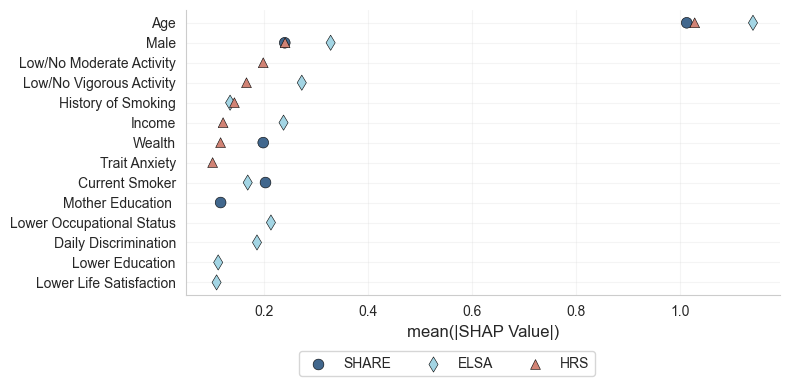

In [27]:
import matplotlib.pyplot as plt
from pathlib import Path 

fontsize_ticks = 12
fontsize_labels = 12
linewidth=0.4
var_dict = model_params['var_dict']
df_shap_plot= df_shaps[['var','HRS',f'ELSA','SHARE']].copy()
df_shap_plot.dropna(thresh=2,inplace=True)
df_shap_plot.sort_values(by=['HRS'],ascending=[False],inplace=True)

fig,ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
ax.scatter(df_shap_plot['SHARE'], df_shap_plot['var'], label='SHARE',color=colors['blue'],marker='o',s=[60]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)
ax.scatter(df_shap_plot[f'ELSA'], df_shap_plot['var'], label='ELSA',color=colors['light_blue'],marker='d',s=[60]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)
ax.scatter(df_shap_plot['HRS'], df_shap_plot['var'], label='HRS',color=colors['red'],marker='^',s=[50]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)

    
ax.grid(axis='both',alpha=0.2)
ylabels = [var_dict[y_tick.get_text()] for y_tick in ax.get_yticklabels()]
ax.set_yticklabels(ylabels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('mean(|SHAP Value|)', fontsize=fontsize_labels)

ax.legend(bbox_to_anchor=(0.7, -0.17),ncol=3)
plt.gca().invert_yaxis()
fig.tight_layout()
del df_shap_plot
plt.savefig(Path.cwd() / f'graphs/model_outputs/shap_overall_ranks_all.pdf')


## SHAP Ranks by age groups 

now we have four df including df_shap_all_COMB, df_shap_all_SHARE,df_shap_all_HRS and df_shap_all_ELSA that store the information of original data + the corresponding shaps, both on train and test dataset

In [28]:
# Define bins and labels
bins = [50, 54, 59, 64, 69, 74, 79, 84, 89, float('inf')]
labels = ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']

# Function to categorize age
def categorize_age(df):
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)
    return df

# Apply function to each dataframe
df_shap_all_COMB = categorize_age(df_shap_all_COMB)
df_shap_all_SHARE = categorize_age(df_shap_all_SHARE)
df_shap_all_HRS = categorize_age(df_shap_all_HRS)
df_shap_all_ELSA = categorize_age(df_shap_all_ELSA)
df_shap_all_COMB_ELSA = categorize_age(df_shap_all_COMB_ELSA)

plot HRS,SHARE and COMB into the same plot 

first rows: common factors 
second rows of plot: by different datasets (their own risk factors) 

common risk factors 

In [29]:
# absolute levels
import numpy as np 
shap_cols = [x for x in df_shap_all_HRS.columns if 'shap' in x]
for col in shap_cols:
    df_shap_all_HRS[col]=np.abs(df_shap_all_HRS[col])

shap_cols = [x for x in df_shap_all_SHARE.columns if 'shap' in x]
for col in shap_cols:
    df_shap_all_SHARE[col]=np.abs(df_shap_all_SHARE[col])
    
shap_cols = [x for x in df_shap_all_ELSA.columns if 'shap' in x]
for col in shap_cols:
    df_shap_all_ELSA[col]=np.abs(df_shap_all_ELSA[col])
    
    
    
# merge the data into temp
temp_HRS = df_shap_all_HRS.groupby('age_group').mean(numeric_only=True)
temp_HRS.columns = [x+'_HRS' if x!='age_group' else x for x in temp_HRS.columns]

temp_SHARE = df_shap_all_SHARE.groupby('age_group').mean(numeric_only=True)
temp_SHARE.columns = [x+'_SHARE' if x!='age_group' else x for x in temp_SHARE.columns]

temp = pd.merge(left=temp_HRS,left_on='age_group',right=temp_SHARE,right_on='age_group')

temp_ELSA = df_shap_all_ELSA.groupby('age_group').mean(numeric_only=True)
temp_ELSA.columns = [x+'_ELSA' if x!='age_group' else x for x in temp_ELSA.columns]

temp = pd.merge(left=temp,left_on='age_group',right=temp_ELSA,right_on='age_group')


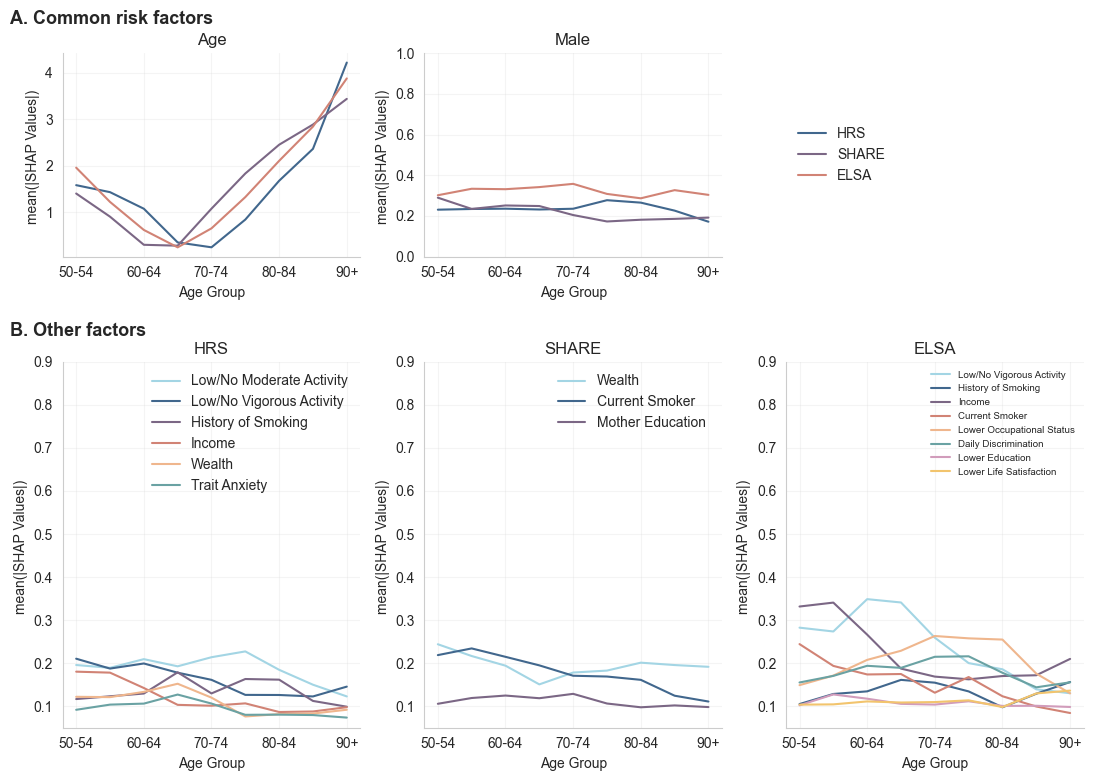

In [30]:
# vars in common = ['age','maleYN','ZwealthT']

from matplotlib import pyplot as plt 
cols_all = ['age_shap','maleYN_shap']
datasets = ['HRS','SHARE','ELSA']
fig,axs = plt.subplots(2,3,figsize=(11, 8),gridspec_kw={'height_ratios': [1, 1.8]})
var_dict = model_params['var_dict']


for j in range(0, 2):
    for i in range(0, 3):
        if j == 0:
            if i==2:
                continue
            col = cols_all[i]
            cols = [f'{col}_{y}' for y in datasets]
            
            if i == 0 and j == 0:
                temp.plot(y=cols, ax=axs[j, i], title=var_dict[col.replace("_shap", '')],color=list(colors.values())[1:4]).legend(loc='best')
                axs[j, i].legend(['HRS', 'SHARE', 'ELSA'],frameon=False)
            else:
                temp.plot(y=cols, ax=axs[j, i], title=var_dict[col.replace("_shap", '')],color=list(colors.values())[1:4], legend=False)
            
        else:
            dataset = datasets[i]
            
            y_cols = [f'{x}_shap_{dataset}' for x in df_shaps.loc[df_shaps[dataset].notnull(), 'var']]
            for col in cols_all:
                y_cols.remove(f'{col}_{dataset}')
            if dataset == "ELSA":
                temp.plot(y=y_cols, ax=axs[j, i], title='ELSA',color=list(colors.values())).legend(loc='best')
                handles, labels = axs[j, i].get_legend_handles_labels()
                axs[j, i].legend([var_dict[x.split("_")[0]] for x in labels],frameon=False,fontsize=7)
            else:
                temp.plot(y=y_cols, ax=axs[j, i], title=dataset,color=list(colors.values())).legend(loc='best')
                handles, labels = axs[j, i].get_legend_handles_labels()
                axs[j, i].legend([var_dict[x.split("_")[0]] for x in labels],frameon=False)
        
        axs[j, i].grid(axis='both',alpha=0.2)
        axs[j, i].set_ylabel('mean(|SHAP Values|) ')
        axs[j, i].set_xlabel('Age Group')
        #axs[j, i].axhline(0, color='grey', ls='--')
        axs[j, i].spines['top'].set_visible(False)
        axs[j, i].spines['right'].set_visible(False)
        
axs[0,1].set_ylim(0.0,1.0)
axs[0,2].visible=False

axs[1,0].set_ylim(0.05,0.9)
axs[1,1].set_ylim(0.05,0.9)
axs[1,2].set_ylim(0.05,0.9)

axs[0,2].clear()
axs[0,2].axis('off')  # Turn off the axis completely

# Move the legend from axs[0,1] to axs[0,2]
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles, ['HRS', 'SHARE', 'ELSA'], frameon=False, loc='center left', fontsize=10)

axs[0,0].legend_.remove()
# Redraw the figure with adjustments
fig.text(0.01, 0.97, "A. Common risk factors", ha='left', va='top', fontsize=13, weight="bold")
fig.text(0.01, 0.58, "B. Other factors", ha='left', va='top', fontsize=13, weight="bold")

# Adjust layout to ensure proper spacing
fig.tight_layout(rect=[0, 0, 1, 0.96], h_pad=3.0)

# Save the modified figure
plt.savefig(Path.cwd() / 'graphs/model_outputs/shap_by_age_group_all.pdf')

### age effect with no absolute values 

In [31]:
 
# merge the data into temp
temp_HRS = df_shap_all_HRS.groupby('age_group').mean(numeric_only=True)
temp_HRS.columns = [x+'_HRS' if x!='age_group' else x for x in temp_HRS.columns]

temp_SHARE = df_shap_all_SHARE.groupby('age_group').mean(numeric_only=True)
temp_SHARE.columns = [x+'_SHARE' if x!='age_group' else x for x in temp_SHARE.columns]

temp = pd.merge(left=temp_HRS,left_on='age_group',right=temp_SHARE,right_on='age_group')

temp_ELSA = df_shap_all_ELSA.groupby('age_group').mean(numeric_only=True)
temp_ELSA.columns = [x+'_ELSA' if x!='age_group' else x for x in temp_ELSA.columns]

temp = pd.merge(left=temp,left_on='age_group',right=temp_ELSA,right_on='age_group')


In [32]:
temp[[x for x in temp.columns if 'age' in x ]]

,age_HRS,age_shap_HRS,age_SHARE,age_shap_SHARE,age_ELSA,age_shap_ELSA
age_group,,,,,,
50-54,52.971469,1.583595,52.499303,1.404283,53.172249,1.958949
55-59,57.028978,1.433692,56.949329,0.907808,57.078464,1.224220
60-64,61.976273,1.078243,61.899811,0.304359,61.900709,0.622889
65-69,67.073725,0.355686,66.906951,0.285370,67.037766,0.249564
70-74,71.893946,0.250607,71.897547,1.079243,71.890026,0.656821
75-79,76.886621,0.845150,76.869802,1.833774,76.824973,1.327877
80-84,81.791851,1.677704,81.765550,2.451072,81.871111,2.105345
85-89,86.660793,2.362553,86.609319,2.883658,86.529745,2.839745
90+,92.371528,4.213441,91.989899,3.434671,91.590909,3.873515


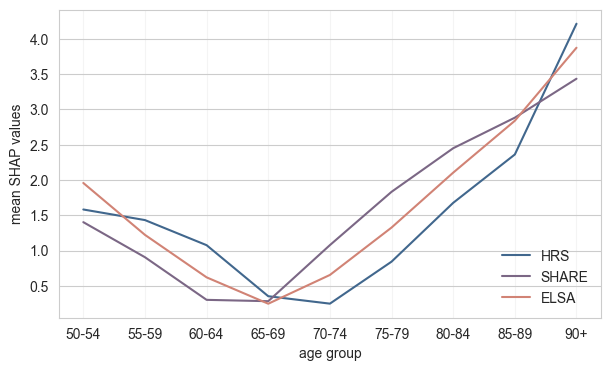

In [33]:
from matplotlib import pyplot as plt 
from pathlib import Path 
fig,ax = plt.subplots(1,1,figsize=(7,4))
temp.plot(y=[f'age_shap_{x}' for x in ['HRS', 'SHARE', 'ELSA']], ax=ax,color=list(colors.values())[1:4]).legend(loc='best')
ax.legend(['HRS', 'SHARE', 'ELSA'],frameon=False,loc='lower right')
ax.set_ylabel('mean SHAP values')
ax.set_xlabel('age group')
ax.grid(axis='x',alpha=0.2)

plt.savefig(Path.cwd() / 'graphs/model_outputs/shap_age.pdf')

# SuperLearner 

In [35]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner
import random 
import warnings
warnings.filterwarnings('ignore')
#platform = "jupyter"
#params.confirm_cwd(platform)
model_params = params.model_params

# specification
model_params['k'] = 10
model_params['y_colname'] = 'death'

## HRS

In [36]:
seeds_lst = pd.read_csv("/Users/valler/Python/OX_Thesis/OX_thesis/results/sl_results_before_change_ffc_r2/sl_10seeds_HRS.csv")['seed'].unique().tolist()

In [37]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain = 'all'

df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    # used to be seed = random.randint(a=1,b=2**32 - 1)
    seed = seeds_lst[i]
    model_params['seed']=seed 
    print(seed)
    domain_lst = model_params['domain_dict'][domain]
    domain_lst.sort()
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=domain_lst,
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
df_eva_10_seeds  

957810778
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
4221110662
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
901450009
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
2507563457
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
1830054538
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3829690777
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
2309658613
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3316367278
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
984794136
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3267513483
9247 9247
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


,model,pr_auc,roc_auc,f1,fb,efron,ffc,ip,imv,seed
0,XGB,0.665408,0.793276,0.755488,0.528408,0.209791,0.209847,0.315021,0.130390,3267513483
1,LGB,0.702656,0.820749,0.776432,0.559887,0.290039,0.290090,0.315021,0.204226,3267513483
2,SGD,0.696602,0.810939,0.760030,0.370038,-0.091781,-0.091703,0.315021,-0.265788,3267513483
3,DecisionTree,0.584628,0.636840,0.681807,0.510317,-0.464837,-0.464733,0.315021,-0.265788,3267513483
4,AdaBoost,0.700573,0.819303,0.773656,0.560152,-0.120881,-0.120801,0.315021,-0.147213,3267513483
...,...,...,...,...,...,...,...,...,...,...
8,KNeighbors,0.640360,0.755878,0.754984,0.508689,0.165623,0.165628,0.316535,-0.269624,957810778
9,Bagging,0.646922,0.773711,0.758516,0.504494,0.202328,0.202333,0.316535,-0.269624,957810778
10,RandomForest,0.624852,0.759578,0.751956,0.433910,0.190654,0.190659,0.316535,-0.269624,957810778
11,ExtraTrees,0.588647,0.744328,0.738077,0.405145,0.162327,0.162332,0.316535,-0.269624,957810778


In [38]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_HRS.csv',index=False)

## SHARE

In [39]:
seeds_lst = pd.read_csv(Path.cwd()/'results/sl_results_before_change_ffc_r2/sl_10seeds_SHARE.csv')['seed'].unique().tolist()
print(seeds_lst)
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()

df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = seeds_lst[i]
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain_name],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
  

[1456187895, 376365506, 345984388, 2224401561, 3910885221, 2246471437, 3219906635, 4012237737, 3180026400, 3567355414]
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
12472 12472
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


In [40]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_SHARE.csv',index=False)

## ELSA

In [41]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
seeds_lst = pd.read_csv(Path.cwd()/'results/sl_results_before_change_ffc_r2/sl_10seeds_ELSA.csv')['seed'].unique().tolist()
print(seeds_lst)

domain = 'ELSA'
model_params['domain_dict'][domain]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain].sort()
df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = seeds_lst[i]
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
df_eva_10_seeds

[4265120468, 521690276, 4032236712, 2257922898, 1234480529, 4208471296, 1484335824, 4081893561, 2146712120, 232144218]
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5872 5872
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


,model,pr_auc,roc_auc,f1,fb,efron,ffc,ip,imv,seed
0,XGB,0.504380,0.829898,0.841478,0.385185,0.193744,0.194042,0.166723,0.058889,232144218
1,LGB,0.516738,0.834760,0.842670,0.371016,0.227220,0.227506,0.166723,0.072597,232144218
2,SGD,0.617261,0.821822,0.692094,0.672034,-1.116605,-1.115822,0.166723,-0.394572,232144218
3,DecisionTree,0.436552,0.627323,0.780294,0.388964,-0.528550,-0.527985,0.166723,-0.394572,232144218
4,AdaBoost,0.551809,0.839259,0.855383,0.383451,-0.660173,-0.659559,0.166723,-0.265647,232144218
...,...,...,...,...,...,...,...,...,...,...
8,KNeighbors,0.444571,0.750162,0.832737,0.371690,0.082647,0.082789,0.170300,-0.400680,4265120468
9,Bagging,0.455787,0.768818,0.841478,0.342573,0.117915,0.118051,0.170300,-0.400680,4265120468
10,RandomForest,0.441284,0.776557,0.842670,0.322581,0.142202,0.142335,0.170300,-0.400680,4265120468
11,ExtraTrees,0.424512,0.772722,0.841081,0.286863,0.134413,0.134547,0.170300,-0.400680,4265120468


In [42]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_ELSA.csv',index=False)

## Combed data 

In [ ]:
for comb_type in [1,2,3,4]:
    domain_name = 'combination_all'
    df,domain_lst = params.read_merged_data(type=comb_type)
    model_params['domain_dict'][domain_name]=domain_lst

    df,model_params['domain_dict'][domain_name]= params.read_merged_data(type=comb_type)
    model_params['domain_dict'][domain_name].sort()
    #model_params['domain_dict'][domain_name].remove('hhid')
    #model_params['domain_dict'][domain_name].remove('pn')
    model_params['var_dict']['dataset']='Datasource'

    df_eva_10_seeds = pd.DataFrame()
    seeds_lst = pd.read_csv(Path.cwd()/f'results/sl_results_before_change_ffc_r2/sl_10seeds_COMB_{comb_type}.csv')['seed'].unique().tolist()
    print(seeds_lst)

    for i in range(0, 10):
        print(i)
        seed = seeds_lst[i]
        model_params['seed']=seed 
        superlearner = SuperLearner.superlearner(data=df,
                                test_size=model_params['test_size'],
                                domain_list=model_params['domain_dict'][domain_name],
                                y_colname=model_params['y_colname'],
                                k=model_params['k'],
                                random_state=seed,
                                train_subset_size=1)
        df_eva=sl_eva(superlearner)
        df_eva['seed']=[seed]*len(df_eva)
        df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
    df_eva_10_seeds.to_csv(Path.cwd()/f'results/sl_10seeds_COMB_{comb_type}.csv',index=False)
    df_eva_10_seeds  

[446456794, 959824433, 1400696266, 1650692339, 3497536612, 272692358, 2080527319, 2653870572, 1747039382, 2374933757]
0
27591 27591
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
1
27591 27591
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
2
27591 27591
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3
27591 27591
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
4
27591 27591
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5
27591 27591
fold 1
fold 2
fold 3


## Table 2
## Table 2

In [ ]:
import warnings
import pandas as pd
from pathlib import Path
warnings.simplefilter("ignore") 
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'All Three Datasets','COMB_2':'HRS + SHARE','COMB_3':'HRS + ELSA','COMB_4':'SHARE + ELSA'}


In [ ]:
df_table_1 = pd.DataFrame()
df_table_1_std = pd.DataFrame()
for dataset in ['HRS','SHARE','ELSA','COMB_1','COMB_2','COMB_3','COMB_4']:
    df_eva_10_seeds = pd.read_csv(Path.cwd()/f'results/sl_10seeds_{dataset}.csv')
    for model in ['sl','LGB','LogisticRegression']:
        temp = pd.DataFrame(df_eva_10_seeds.loc[df_eva_10_seeds['model']==model].mean()).T
        temp_std = pd.DataFrame(df_eva_10_seeds.loc[df_eva_10_seeds['model']==model].std()/np.sqrt(10)).T

        temp.loc[len(temp)-1,['model','dataset']]=[model,dataset]
        temp_std.loc[len(temp_std)-1,['model','dataset']]=[model,dataset]

        df_table_1=pd.concat([df_table_1,temp],axis=0)
        df_table_1_std = pd.concat([df_table_1_std,temp_std],axis=0)

In [ ]:
# table 2, latex format 
for datasets in [['HRS','SHARE','ELSA'],['COMB_2','COMB_3','COMB_4'],['COMB_1']]: 
    if len(datasets)!=1:
        print(table_name_dict[datasets[0]],table_name_dict[datasets[1]],table_name_dict[datasets[2]])
    
        for eva in ['imv','roc_auc','pr_auc','efron','ffc','ip']:

            print()

            print("{}   & {:.3f} &  {:.3f} &  {:.3f} & {:.3f} &  {:.3f} &  {:.3f} & {:.3f} &  {:.3f}&  {:.3f} \\\\".format(eva.upper().replace('_',' '),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3)))
            print()
            print("{}   & ({:.3f}) &  ({:.3f}) &  ({:.3f}) & ({:.3f}) &  ({:.3f}) &  ({:.3f}) & ({:.3f}) &  ({:.3f})&  ({:.3f}) \\\\".format('',
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[0])&(df_table_1_std['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[0])&(df_table_1_std['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[0])&(df_table_1_std['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[1])&(df_table_1_std['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[1])&(df_table_1_std['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[1])&(df_table_1_std['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[2])&(df_table_1_std['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[2])&(df_table_1_std['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[2])&(df_table_1_std['model']=='LogisticRegression'),eva].values[0],3)))

    else:
        print(table_name_dict[datasets[0]])
        for eva in ['imv','roc_auc','pr_auc','efron','ffc','ip']:
            print("{}   & \multicolumn{{3}}{{c}}{{{:.3f}}} &  \multicolumn{{3}}{{c}}{{{:.3f}}} & \multicolumn{{3}}{{c}}{{{:.3f}}} \\\\".format(eva.upper().replace('_',' '),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3)))
            print()
            print("{}   & \multicolumn{{3}}{{c}}{{({:.3f})}} &  \multicolumn{{3}}{{c}}{{({:.3f})}} & \multicolumn{{3}}{{c}}{{({:.3f})}} \\\\".format('',
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[0])&(df_table_1_std['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[0])&(df_table_1_std['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1_std.loc[(df_table_1_std['dataset']==datasets[0])&(df_table_1_std['model']=='LogisticRegression'),eva].values[0],3)))
            print()

## Combination

In [ ]:
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=1)
model_params['var_dict']['dataset']='Datasource'

In [ ]:

df_eva_10_seeds = pd.DataFrame()
for i in range(1,9):
    seed = random.randint(a=1,b=1000000000000)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict']['combination_all'],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=model_params['random_state'],
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
    

In [ ]:
df_eva_10_seeds

In [ ]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds.csv',index=False)

In [ ]:
for seed in df_eva_10_seeds['seed'].unique():
    df_eva_10_seeds.loc[(df_eva_10_seeds['seed']==seed)]

# Domain Contribution

In [52]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from src.Domains_Diff_in_combination import get_dc_params,dc_iteration,dd_post_process,dc_plot
model_params = params.model_params

## HRS

In [53]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain_name = 'HRS'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)

pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


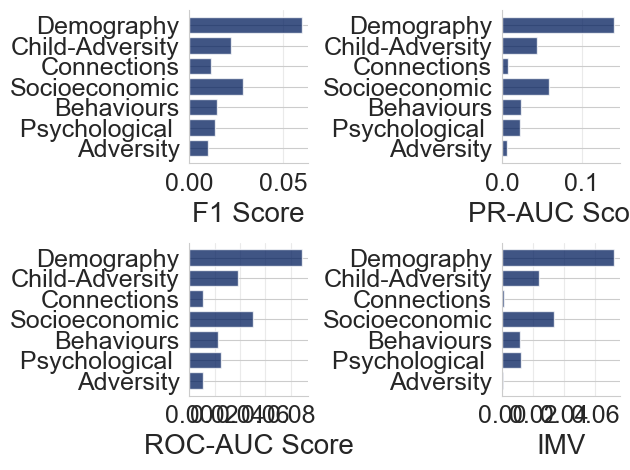

In [54]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain_name = 'HRS'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)


df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_hrs,contribution_hrs = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_hrs,save_control=False)
del df

## SHARE


pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


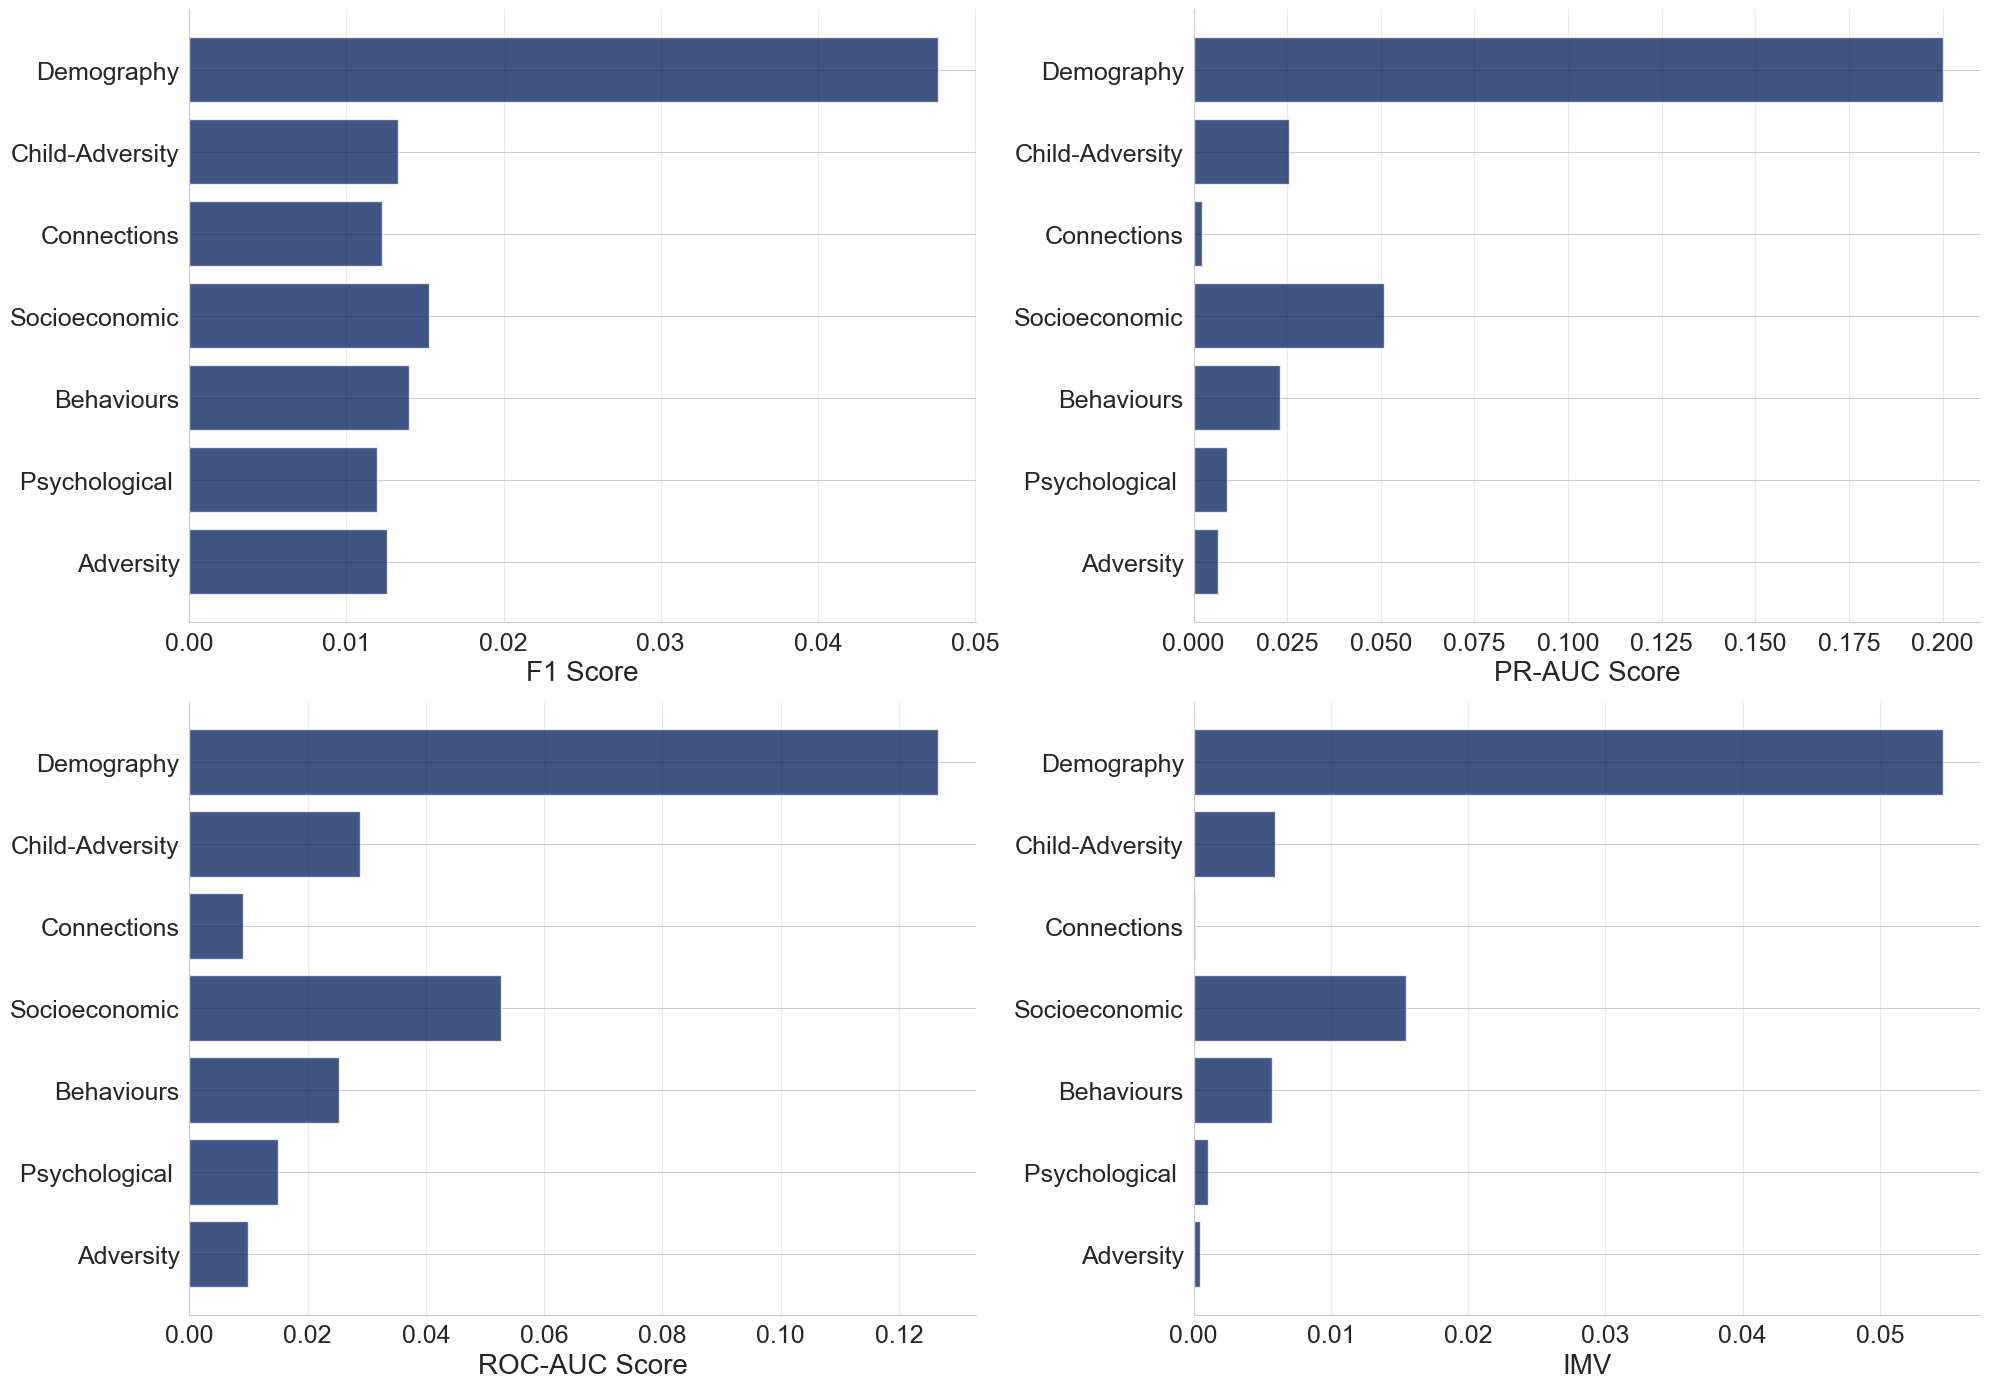

In [55]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict']['share']:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)

df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_share,contribution_share = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_share,save_control=False)
del df 

## ELSA

In [56]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'ELSA'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))


there are 6 domains and 63 iterations
pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


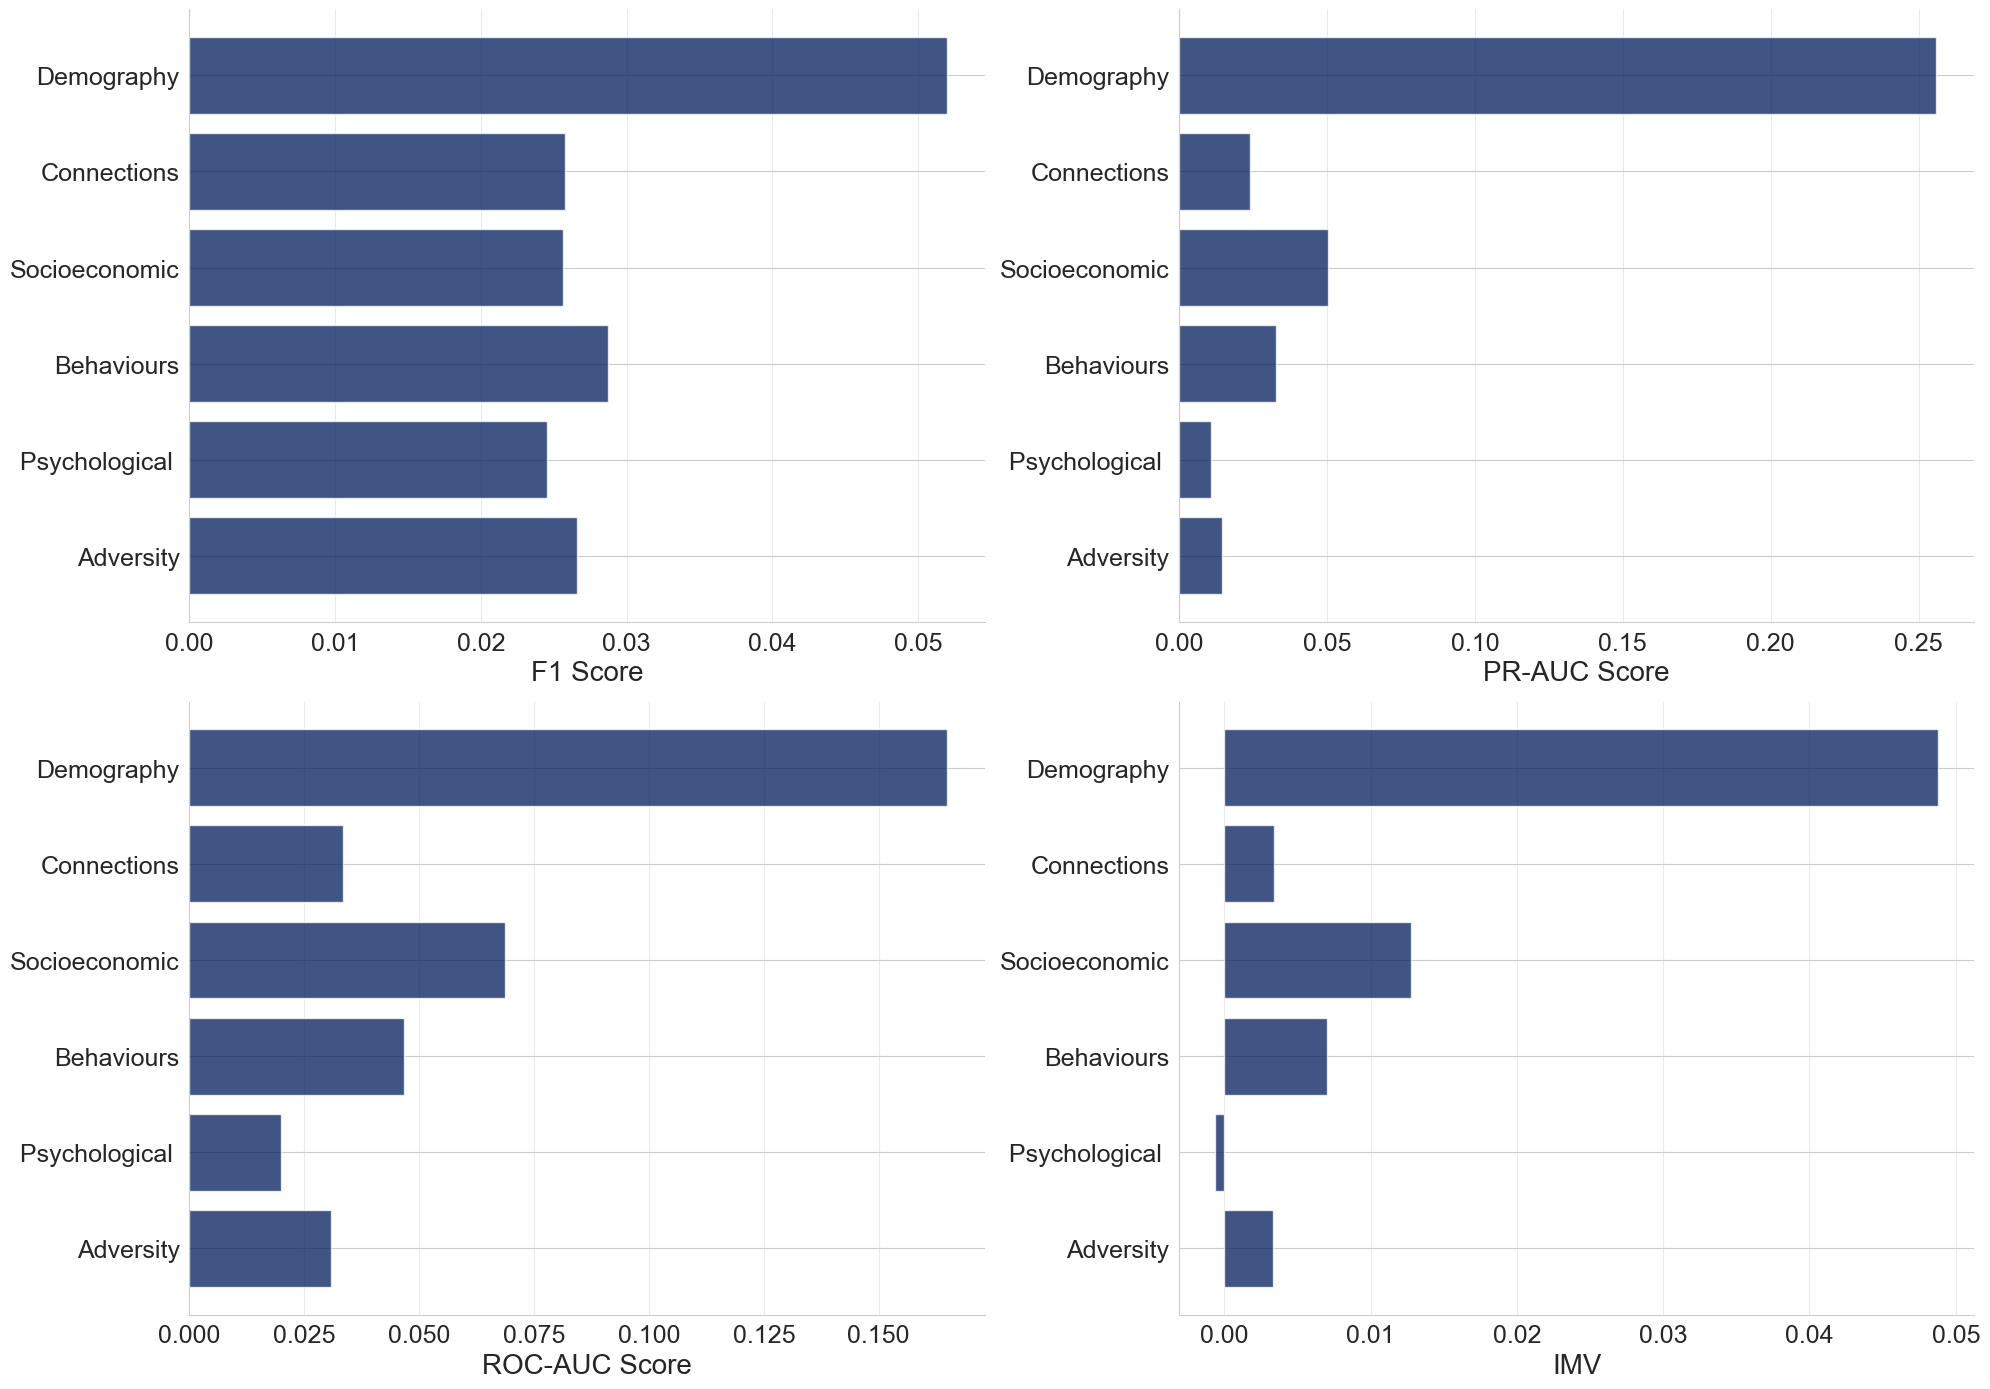

In [57]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)
print(f'there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_elsa,contribution_elsa = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_elsa,save_control=False)
del df 

## Combination

In [58]:
comb_type = 1
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type = comb_type)
model_params['var_dict']['dataset']='Datasource'


In [59]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)
print(f'there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

there are 4 domains and 15 iterations


pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


FixedFormatter should only be used together with FixedLocator


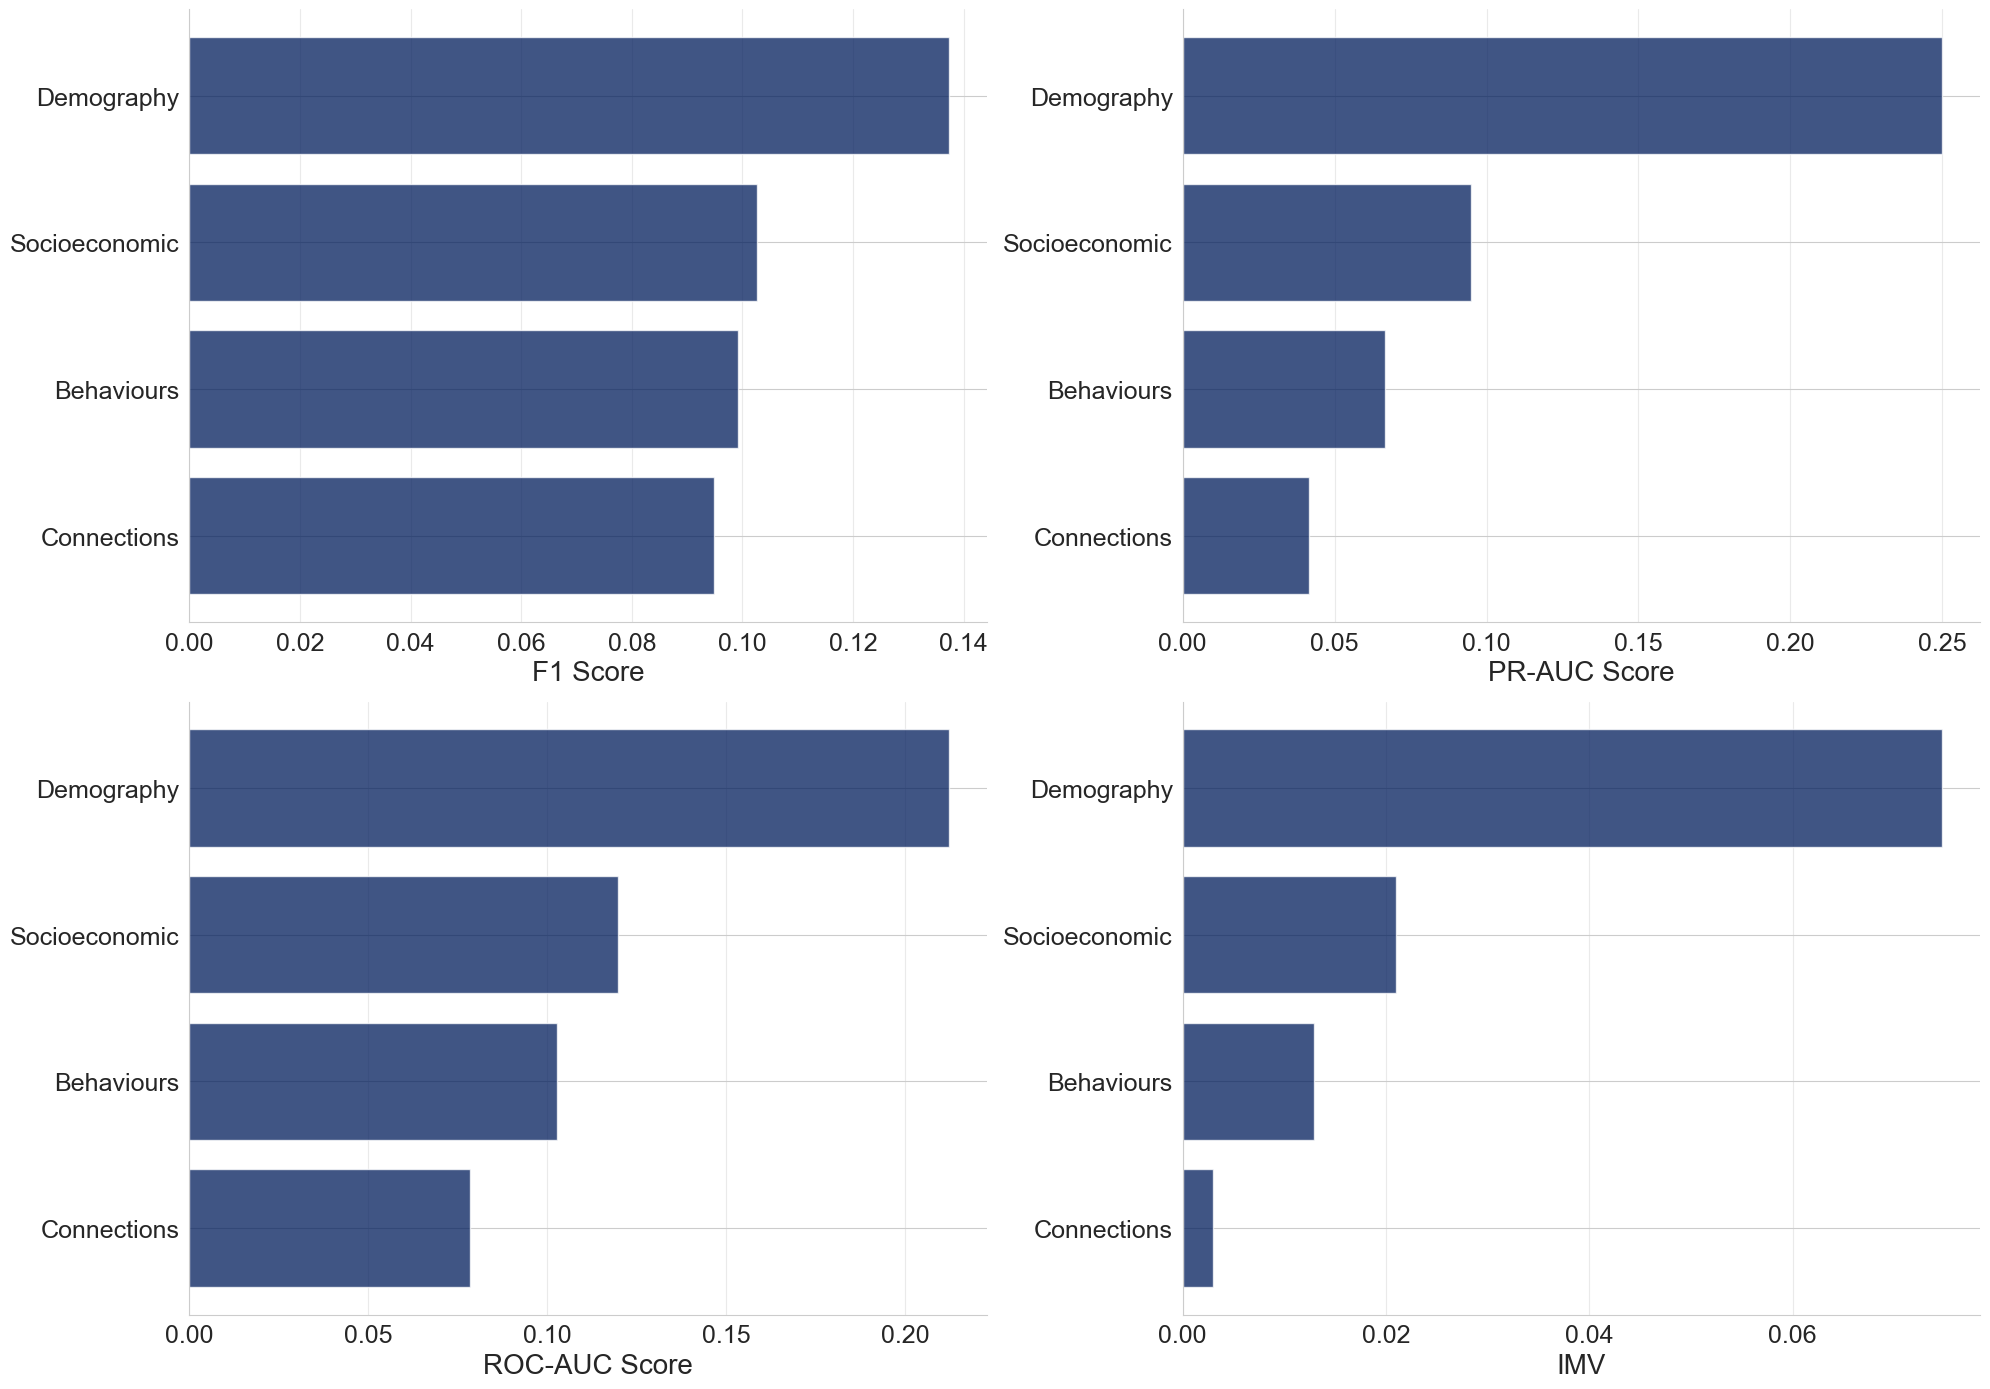

In [60]:
df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_comb,contribution_comb = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_comb,save_control=False)

In [61]:
from pathlib import Path
contribution_comb['dataset']='comb'
contribution_hrs['dataset']='hrs'
contribution_share['dataset']='share'
contribution_elsa['dataset']='elsa'

contribution = pd.concat([contribution_comb,contribution_hrs,contribution_share,contribution_elsa],axis=0)
contribution.to_csv(Path.cwd()/'results/domain_contribution_all_lgb_20250124.csv')

## Figrue 2: Domain Contribution

In [ ]:
import pandas as pd 
from pathlib import Path
contribution=pd.read_csv(Path.cwd()/'results/domain_contribution_all_lgb_20250124.csv',index_col=0)

In [62]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

for domain in basic_domains:
    for dataset in contribution.dataset.unique():
        if contribution.loc[(contribution['goal_domain']==domain)&(contribution['dataset']==dataset)].shape[0]==0:
            contribution=pd.concat([contribution,pd.DataFrame({'goal_domain':[domain],'dataset':dataset,'pr_auc_contribution':[None],'roc_auc_contribution':[None],'imv_contribution':[None],'pr_f1_contribution':[None]})],axis=0)
            

In [63]:
colors = {
    'light_blue': '#a3d5e4',  # Existing light blue
    'blue': '#41678d',        # Existing blue
    'purple': '#7b6785',      # Existing purple
    'red': '#d18375',         # Existing red
    'peach': '#efb68d',       # Existing peach
    'teal': '#6aa2a3',        # New teal color
    'soft_pink': '#d19cbb',   # New soft pink color
    'warm_yellow': '#f2c46d'  # New warm yellow color
}

import matplotlib.pyplot as plt
import numpy as np

orders= {'adult_adverse': 6, 'adult_SES': 3, 'social_connection': 2, 'psych': 0, 'demographic': 5, 'behavioral': 4, 'child_adverse': 1}
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}
figure = plt.figure()
fontsize_ticks = 14
fontsize_labels = 16
plt.rcParams["figure.figsize"] = [13,12]
figure.subplots_adjust(left=0.12, bottom=0.1,top=0.995,right=0.995)
datasets = ['hrs','share','elsa','comb']
eva_score = 'pr_auc'

for m in range(1, 5):
    df = contribution.loc[contribution['dataset'] == datasets[m - 1]].copy()
    df['order'] = [orders[x] for x in df['goal_domain']]

    df.sort_values(by=['order'], inplace=True)
    
    # Replace NaN contributions with 0 but keep track for labels
    
    df[f'{eva_score}_contribution'].fillna(0, inplace=True)
    
    # Prepare the values for the plot
    values = list(df[f'{eva_score}_contribution'])
    values += [values[0]]
    labels = [
    replace_name_dict[x] if not np.isnan(original) else "NaN"
    for x, original in zip(df['goal_domain'], contribution[f'{eva_score}_contribution'])
]
    
    # Get the angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, len(orders), endpoint=False).tolist()
    angles += angles[:1]
    angles = [x + 0.1 for x in angles]  # Close the heptagon

    # Create the subplot for each dataset
    axis = figure.add_subplot(int(f'22{m}'), polar=True)

    # Plot the heptagon shape
    axis.plot(angles, values, color='black', linewidth=1.2, linestyle='solid')
    axis.fill(angles, values, color=colors['blue'])

    # Adjust the y-axis limits
    
    
    if datasets[m - 1] == 'elsa':
        axis.set_ylim([-0.01, 0.25])
    
    elif datasets[m - 1] == 'comb':
        axis.set_ylim([0.0, 0.25])
    else:
        axis.set_ylim([0, max(contribution[f'{eva_score}_contribution'])])

    # Set the labels for each dimension

    
    axis.set_xticks(angles[:-1])
    axis.set_xticklabels([])
    
    
    axis.spines['polar'].set_visible(False)
    
    if datasets[m-1]=='comb':
        axis.text(1.67,0.31,"ALL", ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    elif datasets[m-1]=='elsa':
        axis.text(1.67,0.31,datasets[m-1].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    else:
        axis.text(1.67,0.25,datasets[m-1].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    
    # Add the dimension labels
    if datasets[m-1] in ['hrs','share']:
        for i, angle in enumerate(angles[:-1]):
            x = angle
            y = 0.220
            axis.text(
                x,
                y,
                f'{labels[i]}\n{round(values[i], 3)}' if values[i]!=0 else f'{labels[i]}\n -',
                ha='center',
                va='center',
                fontsize=fontsize_ticks,
            )
    
            axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5, which='major')
            axis.set_yticklabels([])
    else:
        for i, angle in enumerate(angles[:-1]):
            x = angle
            y = 0.27
            axis.text(
                x,
                y,
                f'{labels[i]}\n{round(values[i], 3)}' if  values[i]!=0 else f'{labels[i]}\n -',
                ha='center',
                va='center',
                fontsize=fontsize_ticks,
            )
    
            axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5, which='major')
            axis.set_yticklabels([])
    # Set the aspect ratio to equal
    axis.set_aspect('equal')
    axis.set_axisbelow(True)

#figure.tight_layout()
plt.savefig(Path.cwd() / 'graphs/model_outputs/domain_contribution_all.pdf')

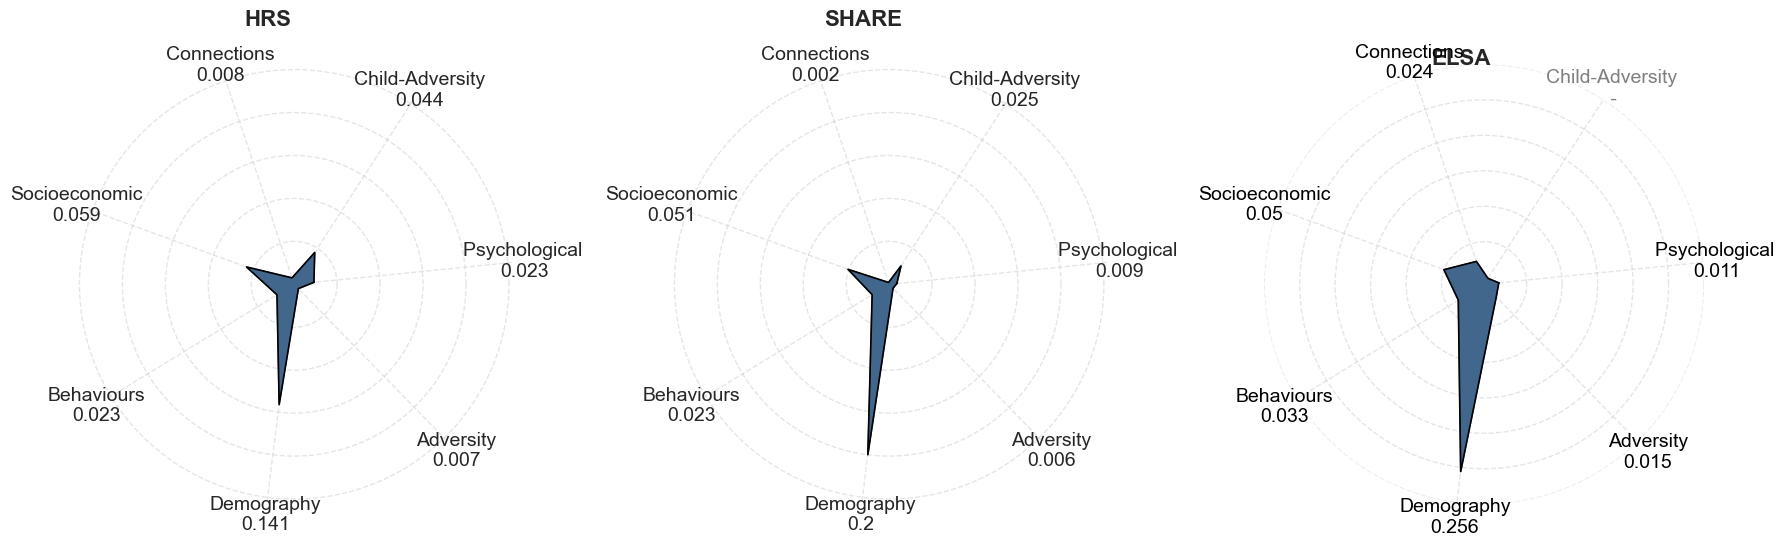

In [67]:
import matplotlib.pyplot as plt
import numpy as np

orders= {'adult_adverse': 6, 'adult_SES': 3, 'social_connection': 2, 'psych': 0, 'demographic': 5, 'behavioral': 4, 'child_adverse': 1}
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}
figure = plt.figure()
fontsize_ticks = 14
fontsize_labels = 16
plt.rcParams["figure.figsize"] = [18,6]
figure.subplots_adjust(left=0.12, bottom=0.1,top=0.995,right=0.995)
datasets = ['hrs','share','elsa']
eva_score = 'pr_auc'

for m in range(1, 4):
    df = contribution.loc[contribution['dataset'] == datasets[m - 1]].copy()
    df['order'] = [orders[x] for x in df['goal_domain']]

    df.sort_values(by=['order'], inplace=True)
    
    # Replace NaN contributions with 0 but keep track for labels
    
    df[f'{eva_score}_contribution'].fillna(0, inplace=True)
    
    # Prepare the values for the plot
    values = list(df[f'{eva_score}_contribution'])
    values += [values[0]]
    labels = [
    replace_name_dict[x] if not np.isnan(original) else "NaN"
    for x, original in zip(df['goal_domain'], contribution[f'{eva_score}_contribution'])
]
    
    # Get the angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, len(orders), endpoint=False).tolist()
    angles += angles[:1]
    angles = [x + 0.1 for x in angles]  # Close the heptagon

    # Create the subplot for each dataset
    axis = figure.add_subplot(int(f'13{m}'), polar=True)

    # Plot the heptagon shape
    axis.plot(angles, values, color='black', linewidth=1.2, linestyle='solid')
    axis.fill(angles, values, color=colors['blue'])

    # Adjust the y-axis limits
    
    
    if datasets[m - 1] == 'elsa':
        axis.set_ylim([-0.01, 0.3])
    
    elif datasets[m - 1] == 'comb':
        axis.set_ylim([0.0, 0.25])
    else:
        axis.set_ylim([0, max(contribution[f'{eva_score}_contribution'])])

    # Set the labels for each dimension

    
    axis.set_xticks(angles[:-1])
    axis.set_xticklabels([])
    
    
    axis.spines['polar'].set_visible(False)
    
    if datasets[m-1]=='comb':
        axis.text(1.67,0.31,"ALL", ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    elif datasets[m-1]=='elsa':
        axis.text(1.67,0.31,datasets[m-1].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    else:
        axis.text(1.67,0.31,datasets[m-1].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    
    # Add the dimension labels
    if datasets[m-1] in ['hrs','share']:
        for i, angle in enumerate(angles[:-1]):
            x = angle
            y = 0.27
            axis.text(
                x,
                y,
                f'{labels[i]}\n{round(values[i], 3)}' if values[i]!=0 else f'{labels[i]}\n -',
                ha='center',
                va='center',
                fontsize=fontsize_ticks,
            )
    
            axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5, which='major')
            axis.set_yticklabels([])
    else:
        for i, angle in enumerate(angles[:-1]):
            x = angle
            y = 0.32
            axis.text(
                x,
                y,
                f'{labels[i]}\n{round(values[i], 3)}' if  values[i]!=0 else f'{labels[i]}\n -',
                ha='center',
                va='center',
                fontsize=fontsize_ticks,
                color ='black' if values[i]!=0 else 'grey')
    
            axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5, which='major')
            axis.set_yticklabels([])
    # Set the aspect ratio to equal
    axis.set_aspect('equal')
    axis.set_axisbelow(True)

figure.tight_layout()
#plt.savefig(Path.cwd() / 'graphs/model_outputs/domain_contribution_single_dataset.pdf')

## Domain contribution for COMB datasets

In [68]:
import warnings
from src import params
warnings.filterwarnings("ignore")
from src.Domains_Diff_in_combination import get_dc_params,dc_iteration,dd_post_process,dc_plot
model_params = params.model_params

In [69]:
df_contribution_comb = pd.DataFrame()
for comb_type in range(1,5):

    domain_name = 'combination_all'
    df,model_params['domain_dict'][domain_name] = params.read_merged_data(type = comb_type)
    model_params['var_dict']['dataset']='Datasource'
    print(len(model_params['domain_dict'][domain_name]),model_params['domain_dict'][domain_name])

    basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

    domains = []
    for var in model_params['domain_dict'][domain_name]:
        for domain in basic_domains:
            if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
                domains+=[domain]
    domains = list(set(domains))+['demographic']

    domain_name_lst,df_eval,iterations = get_dc_params(domains)
    print(f'for {comb_type} there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

    df_eval = dc_iteration(iterations,df_eval,df,model_params)
    model_eval_diff_comb,contribution_comb = dd_post_process(domain_name_lst,iterations,df_eval)
    #dc_plot(contribution_comb,save_control=False)
    contribution_comb['dataset']=str(comb_type)
    df_contribution_comb=pd.concat([df_contribution_comb,contribution_comb],axis=0)

    comb = str(comb_type)
    for domain in basic_domains:
        if df_contribution_comb.loc[(df_contribution_comb['goal_domain']==domain)&(df_contribution_comb['dataset']==comb)].shape[0]==0:
            df_contribution_comb=pd.concat([df_contribution_comb,pd.DataFrame({'goal_domain':[domain],'dataset':[comb],'pr_auc_contribution':[None],'roc_auc_contribution':[None],'imv_contribution':[None],'pr_f1_contribution':[None]})],axis=0)


13 ['Zeduccat', 'ZwealthT', 'age', 'currsmokeYN', 'everdivorced', 'everrent', 'eversmokeYN', 'everunemployed', 'maleYN', 'migrantYN', 'nevermarried', 'rocc', 'vigactivityYN']
for 1 there are 4 domains and 15 iterations
25 ['Zeduccat', 'Zfatherseduc', 'Zhopelessness', 'Zmotherseduc', 'Znegaffect', 'Zoptimism', 'Zperceivedconstraints', 'Zpessimism', 'Zposaffect', 'ZwealthT', 'age', 'currsmokeYN', 'everdivorced', 'everrent', 'eversmokeYN', 'everunemployed', 'fathersocc', 'maleYN', 'migrantYN', 'modactivityYN', 'nevermarried', 'rocc', 'sleepYN', 'sumadultAE', 'vigactivityYN']
for 2 there are 7 domains and 127 iterations
25 ['Zdailydiscrim', 'Zeduccat', 'ZincomeT', 'Zlifesatis', 'Zloneliness', 'Znegchildren', 'Znegfamily', 'Znegfriends', 'Zneighcohesion', 'Zneighdisorder', 'Zposchildren', 'Zposfamily', 'ZwealthT', 'age', 'alcoholYN', 'currsmokeYN', 'everdivorced', 'everrent', 'eversmokeYN', 'everunemployed', 'maleYN', 'migrantYN', 'nevermarried', 'rocc', 'vigactivityYN']
for 3 there are 6 d

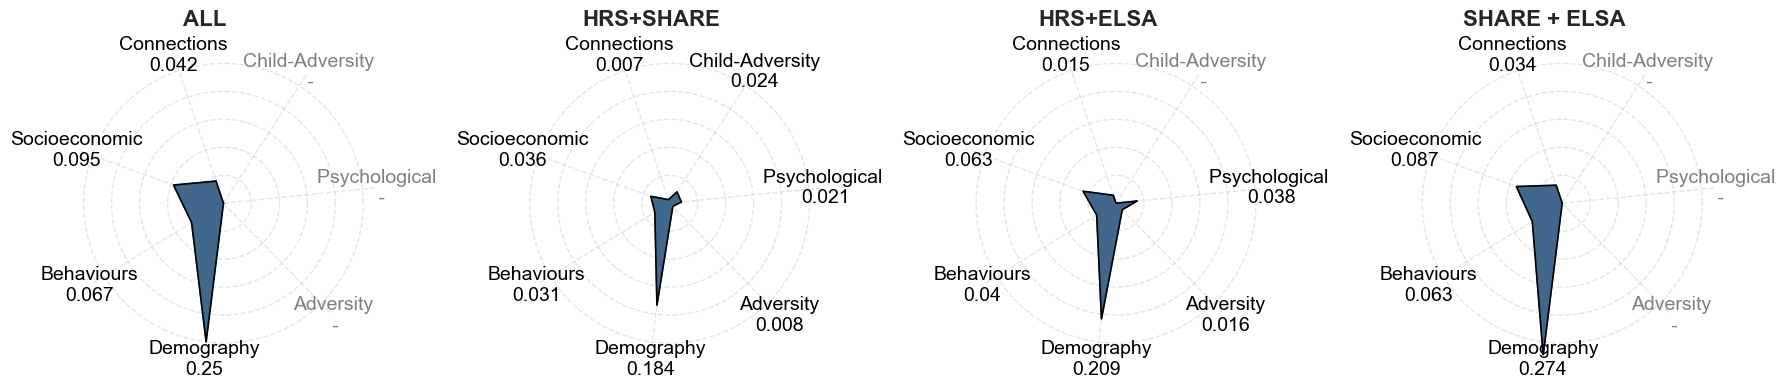

In [70]:
import matplotlib.pyplot as plt
import numpy as np

contribution = df_contribution_comb.copy()
orders= {'adult_adverse': 6, 'adult_SES': 3, 'social_connection': 2, 'psych': 0, 'demographic': 5, 'behavioral': 4, 'child_adverse': 1}
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}
figure = plt.figure()
fontsize_ticks = 14
fontsize_labels = 16
plt.rcParams["figure.figsize"] = [20,8]
figure.subplots_adjust(left=0.12, bottom=0.1,top=0.995,right=0.995)
datasets = [str(x) for x in range(1,5)]

dataset_name_dict= { '1':'All','2':'HRS+SHARE','3':'HRS+ELSA','4':'SHARE + ELSA'}


for m in range(1,5):
    df = contribution.loc[contribution['dataset']==datasets[m-1]].copy()
    df.fillna(0,inplace=True)
    df['order']=[orders[x] for x in df['goal_domain']]

    df.sort_values(by=['order'],inplace=True)

    #df.drop(columns=['order'],inplace=True)

    eva_score = 'pr_auc'

    values = list(df[f'{eva_score}_contribution'])
    values += [values[0]]

    labels = [replace_name_dict[x] for x in df['goal_domain']]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    angles = [x+0.1 for x in angles] # Close the heptagon

    axis = figure.add_subplot(1, 4, m, polar=True)

    # Plot the heptagon shape
    axis.plot(angles, values, color='black', linewidth=1.2, linestyle='solid')
    axis.fill(angles, values, color=colors['blue'])


    axis.set_ylim([0, max(contribution[f'{eva_score}_contribution'])])


    if datasets[m-1]=='elsa':
        print(values)
        axis.set_ylim([-0.01, 0.28])


    # Set the labels for each dimension
    axis.set_xticks(angles[:-1])
    axis.set_xticklabels([])



    axis.spines['polar'].set_visible(False)
    # ax.spines['polar'].set_alpha(0.1)

    # set title
    if datasets[m-1]=='comb':
        axis.text(1.67,0.33,"HRS + ELSA", ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    else:
        axis.text(1.67,0.33,dataset_name_dict[str(m)].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")


    # Add the dimension labels
    for i, angle in enumerate(angles[:-1]):
        x = angle
        y = 0.280
        axis.text(x, y, f'{labels[i]}\n{round(values[i], 3)}' if values[i]!=0 else f'{labels[i]}\n -', ha='center', va='center',fontsize=fontsize_ticks,color ='black' if values[i]!=0 else 'grey')
        axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5,which='major')
        axis.set_yticklabels([])


    # Set the aspect ratio to equal
    axis.set_aspect('equal')
    axis.set_axisbelow(True)
figure.tight_layout()
# Show the plot
#plt.savefig(Path.cwd() / 'graphs/model_outputs/domain_contribution_all_combined_datasets.pdf')
plt.show()

df_contribution_comb

# Asymptotics


In [ ]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva,ffc_rsquare,efron_rsquare
from src import Shap
from src import SuperLearner
import random 

model_params = params.model_params


## LightGBM Version 

In [ ]:
import os
import pathlib
import sys
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner
from src import params
import numpy as np
import pandas as pd
from src.Evaluate import sl_only_eva
from src import SuperLearner
import random

model_params = params.model_params

In [ ]:
# read data 
df,domain_lst = params.read_merged_data(type=3)
domain_name = 'combine_all'
model_params['domain_dict'][domain_name]=domain_lst

In [ ]:


# specification
model_name='lgb'
model_params = params.model_params
model_params['k'] = 5
model_params['y_colname'] = 'death'
domain_name = 'combination_all'

model_params['domain_dict'][domain_name] = ['Zpessimism', 'everunemployed', 'Zperceivedconstraints', 'Zmotherseduc', 'rocc', 'nevermarried', 'ZwealthT', 'age', 'everrent', 'dataset', 'Zoptimism', 'maleYN', 'Znegaffect', 'sleepYN', 'migrantYN', 'fathersocc', 'Zfatherseduc', 'everdivorced', 'Zposaffect', 'currsmokeYN', 'Zhopelessness', 'eversmokeYN', 'Zeduccat', 'modactivityYN', 'vigactivityYN', 'sumadultAE']
model_params['var_dict']['dataset']='Datasource'

# sl initialisation
start = float(0.3)
end = float(1.05)
step=0.05
model='lgb'
seeds = [1981236101, 56317909029, 91833472504,6588504046385,6747454181206,2069405004429]
var_set = model_params['domain_dict'][domain_name]
Eva_fixed_test_size_lgb = pd.DataFrame(columns=['model', 'var_num','train_subset_size', 'test_auc_score', 'test_f1_score', 'test_pr_auc', 'test_pr_no_skill', 'test_efron_r2', 'test_ffc_r2','test_briern_r2', 'test_imv_r2','training_seed'])


In [ ]:

for seed_ind in range(0,len(seeds)):
    Eva_fixed_test_size_lgb = pd.DataFrame(columns=['model', 'var_num','train_subset_size', 'test_auc_score', 'test_f1_score', 'test_pr_auc', 'test_pr_no_skill', 'test_efron_r2', 'test_ffc_r2','test_briern_r2', 'test_imv_r2','training_seed'])


    for train_subset_size in np.arange(start, end, step):

        for sub_set_size in range(1, len(var_set) + 1):
            print(train_subset_size, sub_set_size)
            random.seed(seed_ind)  #
            model_params['domain_dict']['sub_set'] = random.sample(var_set, sub_set_size)
            seed = random.randint(a=1, b=4294967295)
            model_params['random_state'] = seed
            domain_list=model_params['domain_dict']['sub_set']
            model_params['train_on_ELSA_first']=True
            #superlearner = SuperLearner.superlearner(data=df,
            #                                         train_subset_size=train_subset_size,
            #                                         test_size=model_params['test_size'],
            #                                         domain_list=model_params['domain_dict']['sub_set'],
            #                                         y_colname=model_params['y_colname'],
            #                                         k=model_params['k'],
            #                                         random_state=model_params['random_state'])


            model = Models.Model_fixed_test_size(data=df, 
                                                 model_params=model_params, 
                                                 domain=model_params['domain_dict']['sub_set'], 
                                                 model=model_name, 
                                                 train_subset_size=train_subset_size, 
                                                 order=0,)

            evas=metric(model)
            # df_eva.loc[len(df_eva)] = [model, pr_auc, roc_auc, f1, efron, ffc, ip, imv_]
            Eva_fixed_test_size_lgb.loc[len(Eva_fixed_test_size_lgb)] = ['lgb',
                                                                       sub_set_size,
                                                                       int(len(df) * train_subset_size),
                                                                       evas.auc_score,
                                                                       evas.pr_f1,
                                                                       evas.pr_auc,
                                                                       evas.pr_no_skill,
                                                                       evas.efron_rsquare,
                                                                       evas.ffc_r2,
                                                                       evas.brier,
                                                                       evas.imv,
                                                                       seed]

            Eva_fixed_test_size_lgb.to_csv(f"{os.getcwd()}/results/asymptotics_lgb_with_random_sampling_on_vars_seed_specified_{start}_{end}_{seed_ind}{'_train_on_ELSA_first' if model_params['train_on_ELSA_first'] else ''}.csv",index=False)


## Lightgbm plot

In [ ]:
# graphs 
import os 
seeds = [1981236101, 56317909029, 91833472504,6588504046385,6747454181206,2069405004429]
files = [x for x in os.listdir(Path.cwd()/f'results' )if x.startswith(f'asymptotics_lgb_with_random_sampling_on_vars_seed_specified_')]

In [ ]:
train_on_ELSA_first = True 
if train_on_ELSA_first:
    files = [x for x in files if "_train_on_ELSA_first" in x]
else:
    files = [x for x in files if "_train_on_ELSA_first" not in x]

In [ ]:
df = pd.DataFrame()
for file in files:
    if train_on_ELSA_first:
        file_num = int(file[len(file)-25:len(file)-24])
    else:
        file_num = int(file[len(file)-5:len(file)-4])
     
    temp = pd.read_csv(Path.cwd()/f'results/{file}')
    temp['sample_seed'] = seeds[file_num]
    #if file  == 'asymptotics_sl_with_random_sampling_on_vars_seed_specified_0.3_0.4_0.csv':
    #    temp = temp.loc[~temp['train_subset_size']== 22766]
    df = pd.concat([df,temp],axis=0)
    del(temp)


df_avg = df.groupby(['var_num','train_subset_size']).mean()
df_avg.reset_index(inplace=True)

In [ ]:
import matplotlib.colors as mcolors

# Define the colors
colors_blue_purple = ['#41678d', '#d18375','#efb68d']  # blue to purple
# ,'#d18375',
# Create a colormap
cmap_blue_purple = mcolors.LinearSegmentedColormap.from_list("blue_to_purple", colors_blue_purple)


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_avg is already defined and contains the relevant data

columns = []
for column in df.columns:
    if 'test' in column:
        columns.append(column)

df_to_plot = df_avg.drop_duplicates(subset=['train_subset_size', 'var_num']).copy()
df_to_plot.reset_index(inplace=True, drop=True)

# Removing specific columns
columns.remove('test_f1_score')
columns.remove('test_pr_no_skill')
columns.remove('test_ffc_r2')
columns.remove('test_briern_r2')

ploted_col_dict = {
    'test_efron_r2': 'Pesudo R2',
    'test_pr_auc': 'PR-AUC Score',
    'test_auc_score': 'ROC-AUC Score',
    'test_imv_r2': 'IMV'
}

fig, axis = plt.subplots(2, 2)
fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 10]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc', 'test_auc_score', 'test_efron_r2', 'test_imv_r2']

for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    
    # Apply logarithmic scale to the metric data
    # df_to_plot[metric] = np.log1p(df_to_plot[metric])  # Using log1p for log(1 + x) to handle zero values
    
    pivot_table = df_to_plot.pivot('var_num', 'train_subset_size', metric)
    
    # Using a red-blue colormap
    sns.heatmap(pivot_table, ax=axis[m, n], cmap=cmap_blue_purple)  

    axis[m, n].set_ylabel('Variable Number', fontsize=fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size', fontsize=fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric], size=15, weight="bold")

    # Set ticks
    axis[m, n].set_yticks([1, 5, 10, 15, 20, 26])
    axis[m, n].set_yticklabels([1, 5, 10, 15, 20, 26])
    axis[m, n].tick_params(axis='x', rotation=45)

    every_nth = 2
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()):
        if nth % every_nth != 0:
            label.set_visible(False)

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)

    count += 1

fig.tight_layout()

# Save the figure if needed
plt.savefig(Path.cwd()/f'graphs/model_outputs/asymptotics_lgb{"_train_on_ELSA_first" if train_on_ELSA_first else ""}.pdf')



## Superlearner Version 

see the single .py file named 'Asymp_SL.py' in folder 'src'


In [ ]:
# graphs 
import os 
seeds = [1981236101, 56317909029, 91833472504,6588504046385,6747454181206,2069405004429]
files = [x for x in os.listdir(Path.cwd()/'sl/results') if x.startswith('asymptotics_sl_with_random_sampling_on_vars_seed_specified_')]

df = pd.DataFrame()
for file in files:
    file_num = int(file[len(file)-5:len(file)-4])
    temp = pd.read_csv(Path.cwd()/f'sl/results/{file}')
    temp['seed'] = seeds[file_num]
    #if file  == 'asymptotics_sl_with_random_sampling_on_vars_seed_specified_0.3_0.4_0.csv':
    #    temp = temp.loc[~temp['train_subset_size']== 22766]
    df = pd.concat([df,temp],axis=0)
    del(temp)


df_avg = df.groupby(['var_num','train_subset_size']).mean()
df_avg.reset_index(inplace=True)

### graph with only sample size in the x-axis

 here we want to plot the asymptotics graph for the full set of the variables, only subsetting the trainining set size 

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_avf_on_size = df_avg.loc[df_avg['var_num']==26,]


In [ ]:
fig, axis = plt.subplots(2, 2)

fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 6]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2']

ploted_col_dict = {'test_efron_r2': 'Efron R2',
                   'test_pr_auc': 'PR-AUC Score',
                   'test_ffc_r2': 'FFC R2',
                   'test_imv_r2': 'IMV'}


sns.set_style("whitegrid")
for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    
    sns.lineplot(data=df_avf_on_size, x='train_subset_size',y=metric, ax=axis[m, n])

    axis[m, n].set_ylabel(' ',fontsize = fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold")  # , size=fontsize_labels)

    # set ticks
    axis[m, n].tick_params(axis='x', rotation=45)

    
    axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8))

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)


    count += 1
fig.tight_layout()

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl_full_var.pdf')


In [ ]:



ploted_col_dict = {'test_efron_r2': 'Efron R2', 
                        'test_pr_auc': 'PR-AUC Score', 
                        'test_ffc_r2': 'FFC R2', 
                        'test_imv_r2': 'IMV'} 
      
      
fig, axis = plt.subplots(2, 2) 
fontsize_ticks = 13 
fontsize_labels = 15 
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99) 
plt.rcParams['figure.figsize'] = [10, 13] 

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917] 
count = 0 
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2'] 
for (m, n), subplot in np.ndenumerate(axis): 
    metric = columns[count] 
    pivot_table = df_avg.pivot('train_subset_size','var_num',  metric) 
    sns.lineplot(pivot_table, ax=axis[m, n]) 
    axis[m, n].set_ylabel('Variable Number',fontsize = fontsize_labels) 
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels) 
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold" )  # , size=fontsize_labels) 

 # set ticks 

    axis[m, n].tick_params(axis='x', rotation=45) 

    every_nth = 2 
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()): 
        if nth % every_nth != 0: 
            label.set_visible(False) 

 # axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8)) 

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks) 
    axis[m, n].spines['top'].set_visible(False) 
    axis[m, n].spines['right'].set_visible(False) 
    axis[m, n].grid(axis='both', alpha=0.4) 
    axis[m, n].set_axisbelow(True) 



    count += 1 
fig.tight_layout() 

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl_line_look.pdf')

## Figure 3: predictive asymptotics

In [ ]:

# plot
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

columns = []
for column in df.columns:
    if 'test' in column:
        columns.append(column)

df_to_plot = df_avg.drop_duplicates(subset=['train_subset_size', 'var_num']).copy()
df_to_plot.reset_index(inplace=True,drop=True)


columns.remove('test_f1_score')
columns.remove('test_pr_no_skill')
columns.remove('test_auc_score')
columns.remove('test_briern_r2')

ploted_col_dict = {'test_efron_r2': 'Efron R2',
                   'test_pr_auc': 'PR-AUC Score',
                   'test_ffc_r2': 'FFC R2',
                   'test_imv_r2': 'IMV'}


fig, axis = plt.subplots(2, 2)
fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 13]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2']
for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    pivot_table = df_to_plot.pivot('var_num', 'train_subset_size', metric)
    sns.heatmap(pivot_table, ax=axis[m, n], cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True))

    axis[m, n].set_ylabel('Variable Number',fontsize = fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold")  # , size=fontsize_labels)

    # set ticks
    axis[m, n].set_yticks([1, 5, 10, 15, 20, 26])
    axis[m, n].set_yticklabels([1, 5, 10, 15, 20, 26])
    axis[m, n].tick_params(axis='x', rotation=45)

    every_nth = 2
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()):
        if nth % every_nth != 0:
            label.set_visible(False)

    # axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8))

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)



    count += 1
fig.tight_layout()

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl.pdf')

# seed 

## Performance Plot

In [ ]:
from src import seed 

In [ ]:
# perform the seed analysis and store the result in "Path.cwd()/'results/10000seed_comb_model_performance.csv'"
seed.seed_analysis()

In [ ]:

comb_type = 3
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)
model_params['var_dict']['dataset']='Datasource'

df_seed_selection_lst=pd.DataFrame(columns=['seed','model','imv','roc-auc','pr-auc','f1','efron_r2','ffc_r2','IP'])
df_seed_shap_performance_recorder = pd.DataFrame(columns = ['seed','model']+model_params['domain_dict'][domain_name])

count = 0
while count < 10000:
    seed = random.randint(1, 1000000000)
    model_selection = 'lgb'

    model_params['random_state'] = seed
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb', train_subset_size=1, order=0)

    evas = metric(model)

    temp = pd.DataFrame({'seed': seed, 'model': model_selection,
                         'imv': evas.imv, 'roc-auc': evas.auc_score,
                         'pr-auc': evas.pr_auc, 'f1': evas.pr_f1,
                         'efron_r2': evas.efron_rsquare, 'ffc_r2': evas.ffc_r2, 'IP': evas.pr_no_skill}, index=[0])
    df_seed_selection_lst.loc[len(df_seed_selection_lst),] = temp.loc[0,]

    # shap zone
    shap_values_test, shap_dict = Shap.shap_values_and_dict(model)

    # store the mean absolute shap value for each variable in a dictionary
    if len(shap_values_test.shape) == 3:
        shap_values_test.values = shap_values_test.values[:, :, 1]
    shap_dict = {}
    i = 0
    while i < shap_values_test.values.shape[1]:
        sum_shap = 0
        for m in shap_values_test.values[:, i]:
            sum_shap += np.abs(m)
        shap_dict[shap_values_test.feature_names[i]] = sum_shap / shap_values_test.values.shape[0]
        i += 1
    shap_dict['seed'] = seed
    shap_dict['model'] = model_selection
    temp_shap = pd.DataFrame(shap_dict, index=[0])
    df_seed_shap_performance_recorder.loc[len(df_seed_shap_performance_recorder),] = temp_shap.loc[0,]

    del model, evas
    # rest zone
    if count % 100 == 0:
        print(f'now seed is {seed} and we take 10s rest')
        print(f'\n{model_selection} and seed is {seed}, count={count}')
        df_seed_selection_lst.to_csv(Path.cwd() / f'results/10000seed_comb_model_performance_comb_{comb_type}.csv', index=False)
        df_seed_shap_performance_recorder.to_csv(Path.cwd() / f'results/10000seed_comb_shap_values_comb_{comb_type}.csv', index=False)

        time.sleep(10)
    count += 1

df_seed_selection_lst.to_csv(Path.cwd() / f'results/10000seed_comb_model_performance_comb_{comb_type}.csv', index=False)
df_seed_shap_performance_recorder.to_csv(Path.cwd() / f'results/10000seed_comb_shap_values_comb_{comb_type}.csv', index=False)


## Figure 4: Seed 

In [ ]:
import time
import random
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric
from src import Shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')


def draw_brace(ax, mean, y, text):
    brace_width = 0.5
    text_pos_y = 1.08 * y + brace_width

    # Horizontal part (curly brace)
    ax.annotate('', xy=(mean, y), xycoords='data',
                xytext=(mean, text_pos_y), textcoords='data',
                arrowprops=dict(arrowstyle=f']-[, widthB=12, lengthB=0.5,angleB=0,widthA=0,lengthA=0', ),
                annotation_clip=False)

    # Text with expectation and variance
    ax.text(mean, text_pos_y, text, ha='center', va='bottom', fontsize=9,
            bbox=dict(boxstyle='Round', fc='white'))

    
df_eval = df_seed_selection_lst
fig, ax = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [12, 8]
count = 0
colums = ['pr-auc', 'imv', 'efron_r2', 'ffc_r2']
column_dict = {'roc-auc': 'ROC-AUC Score', 'pr-auc': 'PR-AUC Score', 'f1': 'F1', 'efron_r2': 'Efron R2', 'ffc_r2': 'FFC R2', 'imv': 'IMV'}
fig.subplots_adjust(left=0.09, top=0.98, bottom=0.06, right=0.95)

# colors = ['#001c54', '#E89818']

letter_fontsize = 15
label_fontsize = 13
for (m, n), subplot in np.ndenumerate(ax):
    
    sns.distplot(df_eval[colums[count]],
                 hist_kws={'facecolor': colors['blue'], 'edgecolor': 'k', 'alpha':1},
                 kde_kws={'color': colors['orange']}, ax=ax[m, n], bins=20)
    # ax[m,n].hist(df_eval[colums[count]],color=color_blue,alpha=0.75,bins=30,edgecolor='black')
    ax[m, n].set_xlabel(column_dict[colums[count]], fontsize=label_fontsize + 1, weight='bold')
    ax[m, n].set_ylabel('Density', fontsize=label_fontsize + 1)
    ax[m, n].set_axisbelow(True)
    ax[m, n].grid(alpha=0.4,zorder=0)
    ax[m, n].tick_params(axis='both', which='major', labelsize=label_fontsize)

    # annotation part

    stats_text = f"E(PR-AUC)= {df_eval[colums[count]].mean():.2f}, \u03C3(PR-AUC)= {df_eval[colums[count]].std():.3f}"

    draw_brace(ax[m, n],
               df_eval[colums[count]].mean(),
               ax[m, n].get_ylim()[1] * 1.05,
               stats_text)

    count += 1
    ax[m, n].spines['top'].set_visible(False)
    ax[m, n].spines['right'].set_visible(False)

fig.tight_layout()
# plt.show()

plt.savefig(Path.cwd() / 'graphs/model_outputs/seed_lgb_10000_seed_distributions.pdf')


In [ ]:
df_seed_selection_lst=pd.read_csv(Path.cwd()/'results/10000seed_comb_model_performance.csv')
seed.seed_plot(df_seed_selection_lst)

## Table 2 

In [ ]:
df_table_2 = pd.DataFrame(columns=['metric','mean','min','max','standard deviation'])
for metric in ['pr-auc','imv','efron_r2','ffc_r2']:
    df_table_2.loc[len(df_table_2),]=[metric,
                                      df_seed_selection_lst[metric].mean(),
                                      df_seed_selection_lst[metric].min(), 
                                      df_seed_selection_lst[metric].max(), 
                                      df_seed_selection_lst[metric].std()]

In [ ]:
# df_table_2 = pd.DataFrame(columns=['metric','mean','min','max','standard deviation'])
columns =list(df_seed_shap_performance_recorder.columns)
columns.remove('seed')
columns.remove('model')
              
for column in columns:
    if df_seed_shap_performance_recorder[column].mean()>=0.1:
        df_table_2.loc[len(df_table_2),]=[column,
                                          df_seed_shap_performance_recorder[column].mean(),
                                          df_seed_shap_performance_recorder[column].min(), 
                                          df_seed_shap_performance_recorder[column].max(), 
                                          df_seed_shap_performance_recorder[column].std()]


In [ ]:
df_table_2

In [ ]:
replace_dic={'pr-auc':"PR-AUC",
 'imv':"IMV",
 'efron_r2':"Efron $R^2$",
 'ffc_r2':"FFC $R^2$",
 'currsmokeYN':'Current Smoker',
 'age':'Age',
 'modactivityYN':"Low/No Moderate Activity",
 'maleYN':'Male'}
for eva in df_table_2.metric:
    print("& {} & {} & {} & {} & {} \\\\".format(replace_dic[eva],
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'mean'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'min'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'max'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'standard deviation'].values[0],3)))

In [ ]:
for eva in df_table_2.metric:
    print("{}".format(replace_dic[eva],round(df_table_2.loc[(df_table_2['metric']==eva),'max'].values[0]-df_table_2.loc[(df_table_2['metric']==eva),'min'].values[0],3)))
   